# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
import sys

import time
import torch
import torch.hub
import torch.nn

import random
import pickle

# import self-defined MB-simCLR module
from mbsimclr import MbSimCLRModel

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Train and predict based on embeddings of MB-simCLR

## Load data

In [3]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])

In [4]:
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")
copy_gut_16s_df = gut_16s_df.copy()
copy_gut_16s_df['SubjectID'] = [copy_gut_16s_df.index[i][0:7] for i in range(len(copy_gut_16s_df.index))]
gut_16s_df_subj = pd.merge(left=copy_gut_16s_df, right=subjects, how='left', on='SubjectID')
gut_16s_df_subj.index = copy_gut_16s_df.index

In [5]:
# Get indexes for shared patient ids
indexes = list(set(gut_16s_df.index.values) & set(metabolome_df.index.values))
indexes.sort()
print("# of samples: {}".format(len(indexes)))

# of samples: 720


## Train MLPs with different random seeds

In [6]:
random_seed_list = range(1,13)
SAVE_FOLDER = './save_MBsimCLR'
os.makedirs(SAVE_FOLDER, exist_ok=True)

covariate_list = ['IR_IS_classification', 'Sex', 'Race']

dropout_list = np.arange(0.2, 1, 0.2)
weight_decay_list = 0.01*2.**np.linspace(-2,5,8)
temp_list = 0.5*2.**np.linspace(-2,2,5)

## From 1b-v - save and visualize the tuning results_random seeds_1-12
max_idx = dict(list(zip(covariate_list, [(2, 5, 1), (1, 4, 0), (0, 2, 0)])))


IR_IS_classification
n train: 382
n val: 81
n test: 84


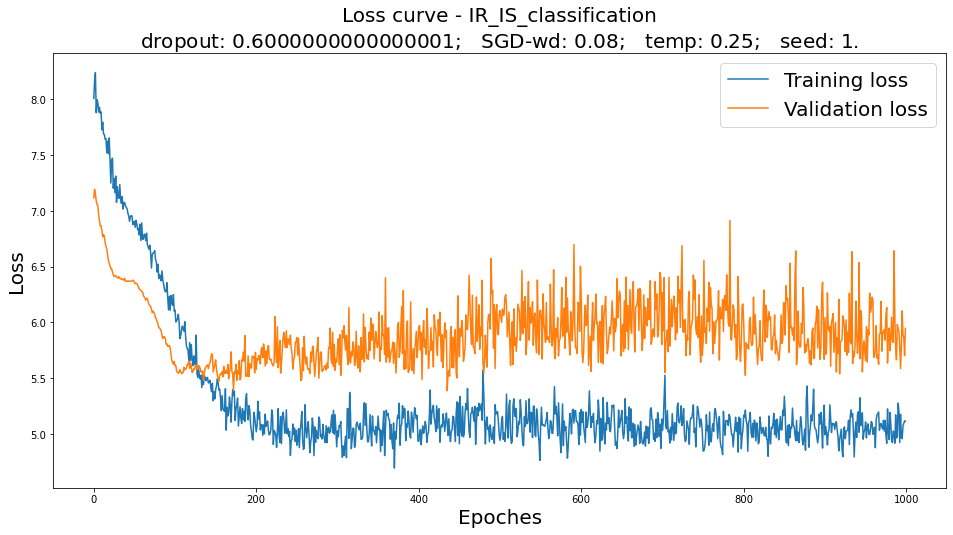

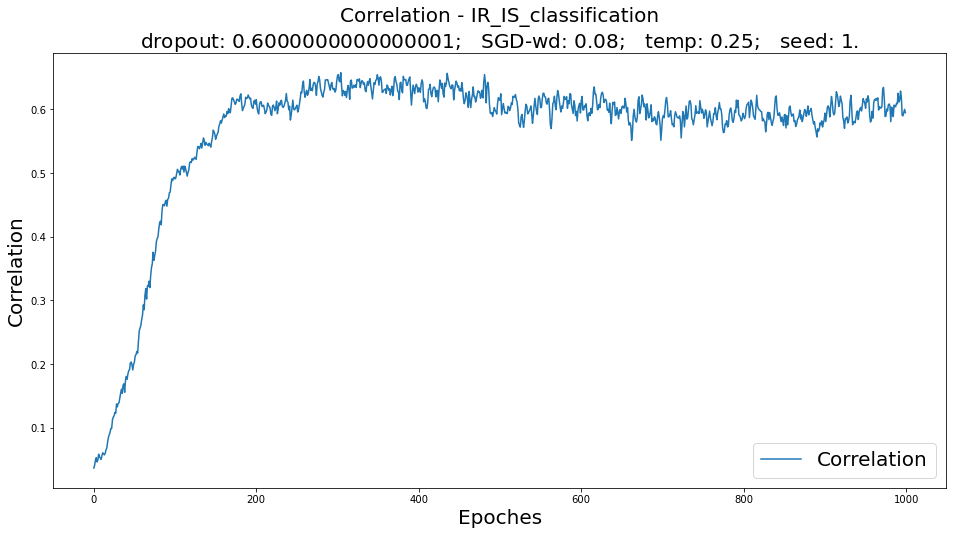

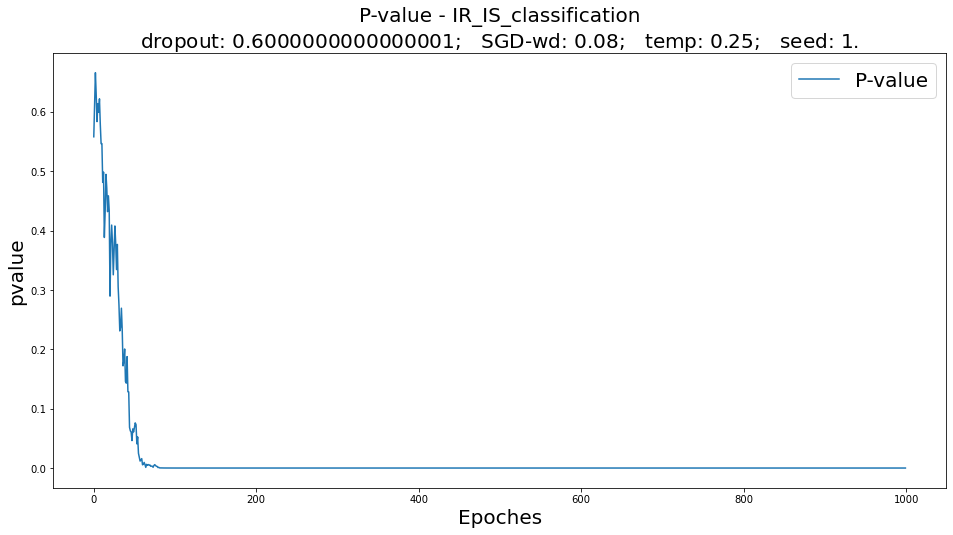


IR_IS_classification
n train: 382
n val: 81
n test: 84


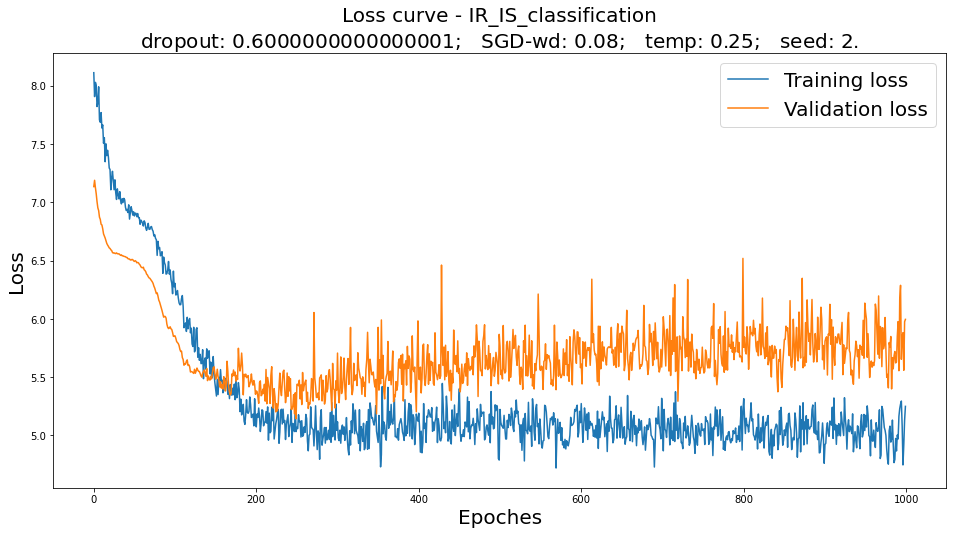

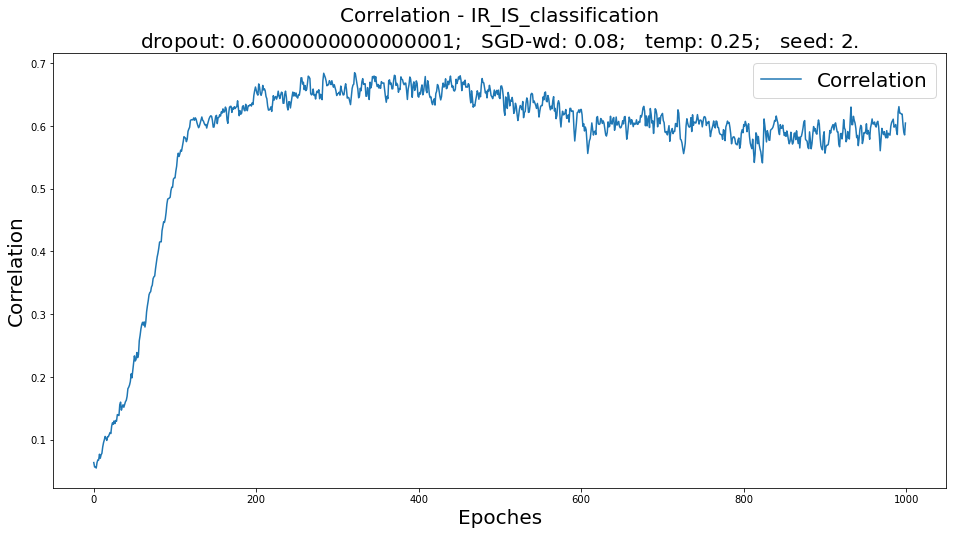

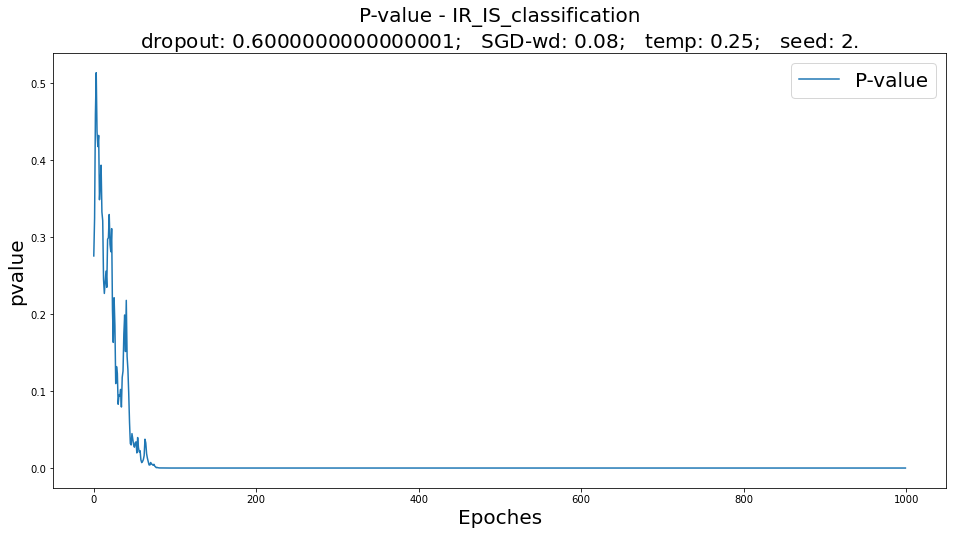


IR_IS_classification
n train: 382
n val: 81
n test: 84


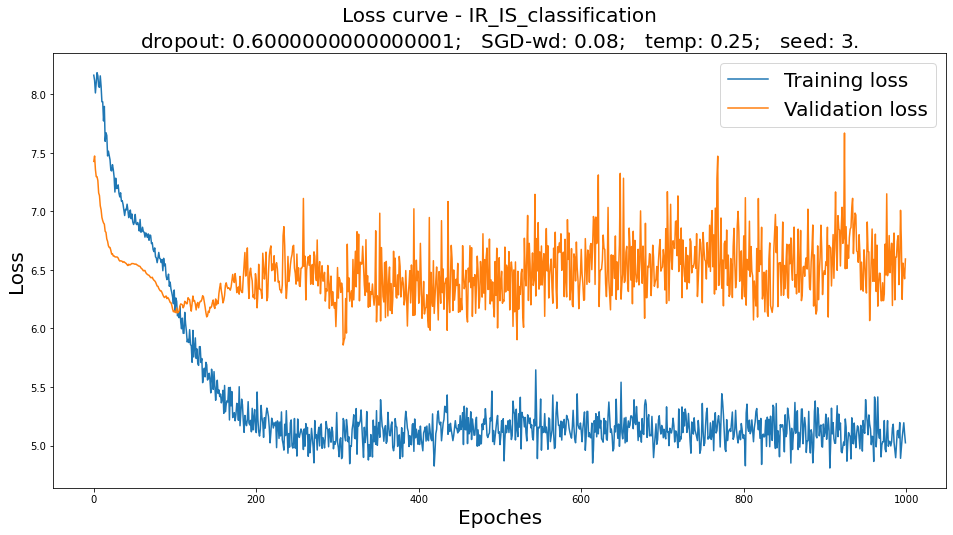

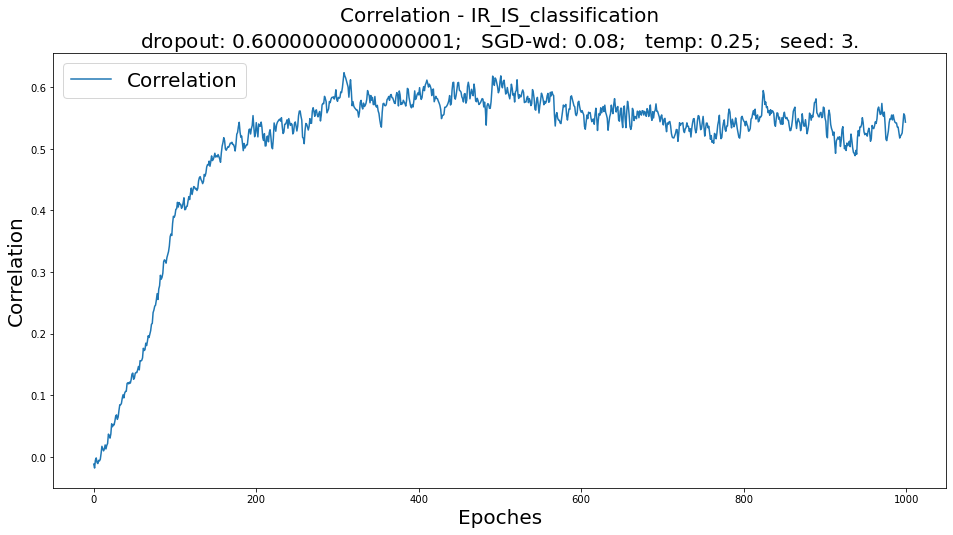

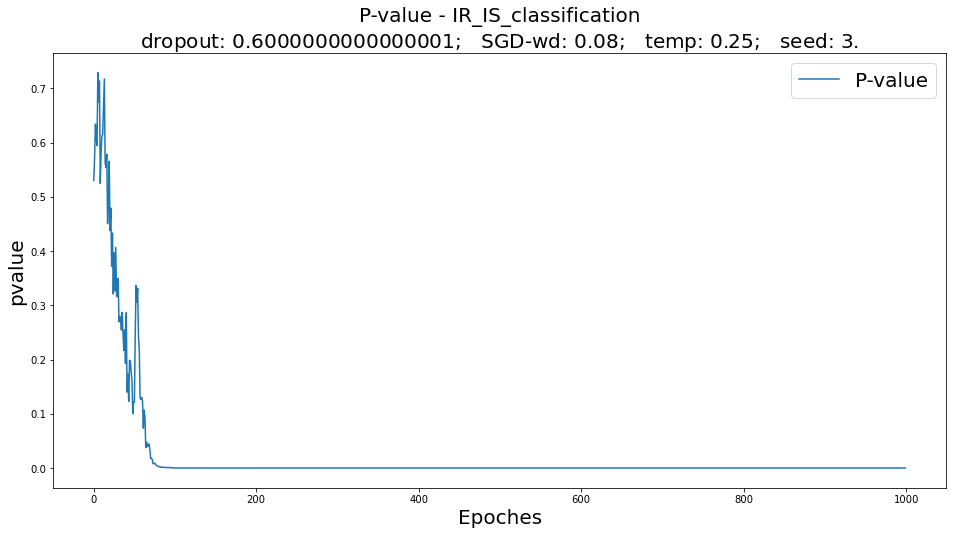


IR_IS_classification
n train: 382
n val: 81
n test: 84


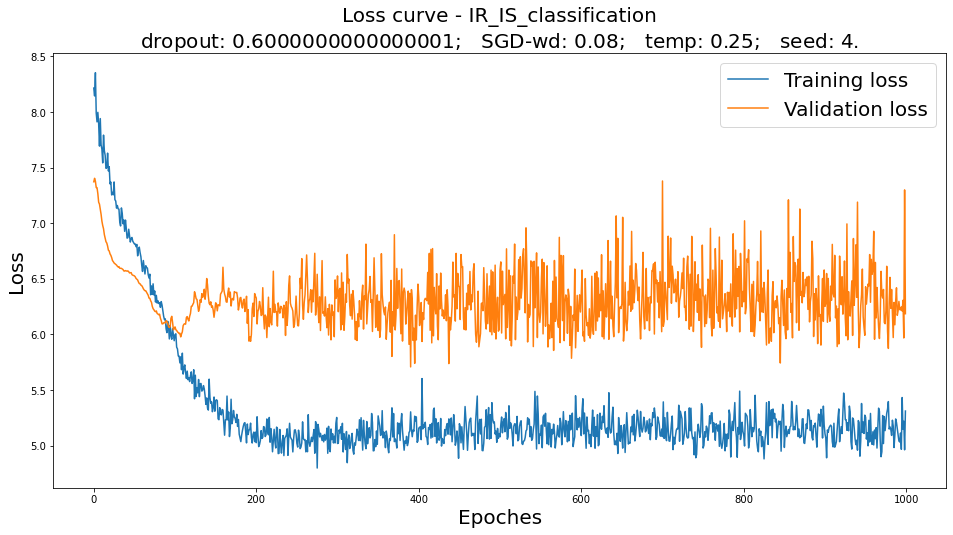

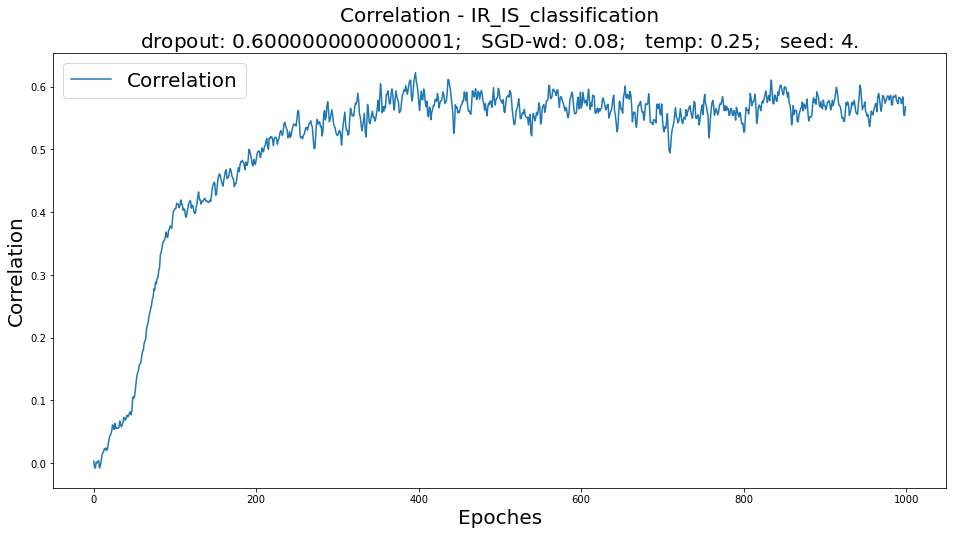

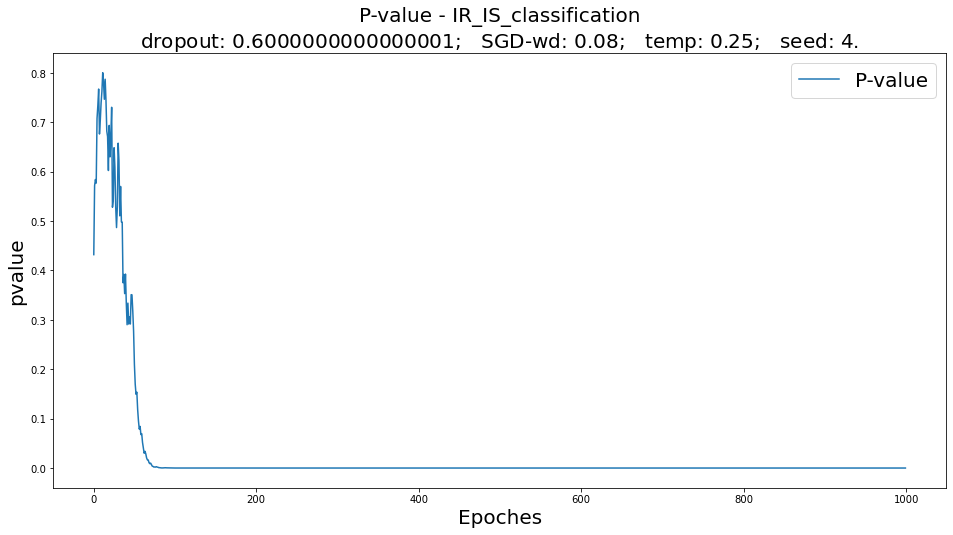


IR_IS_classification
n train: 382
n val: 81
n test: 84


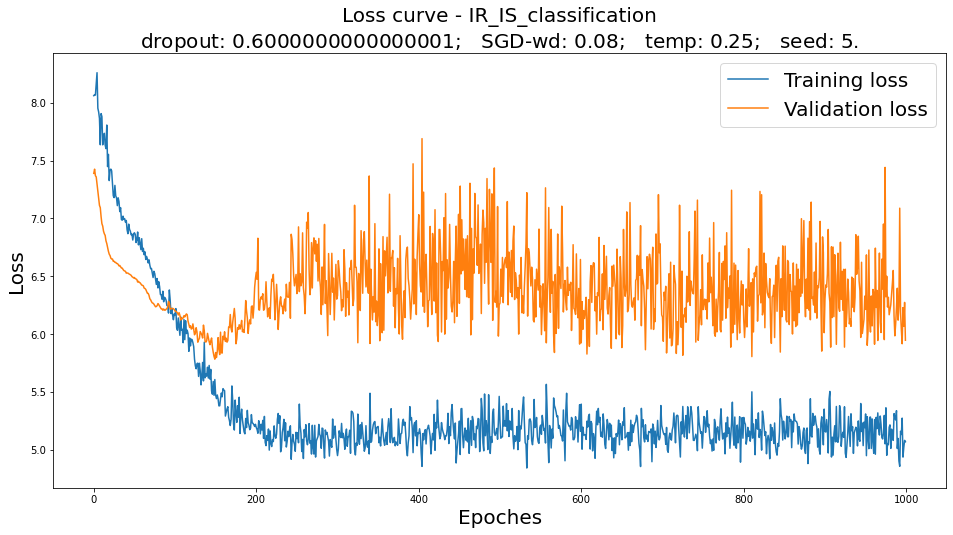

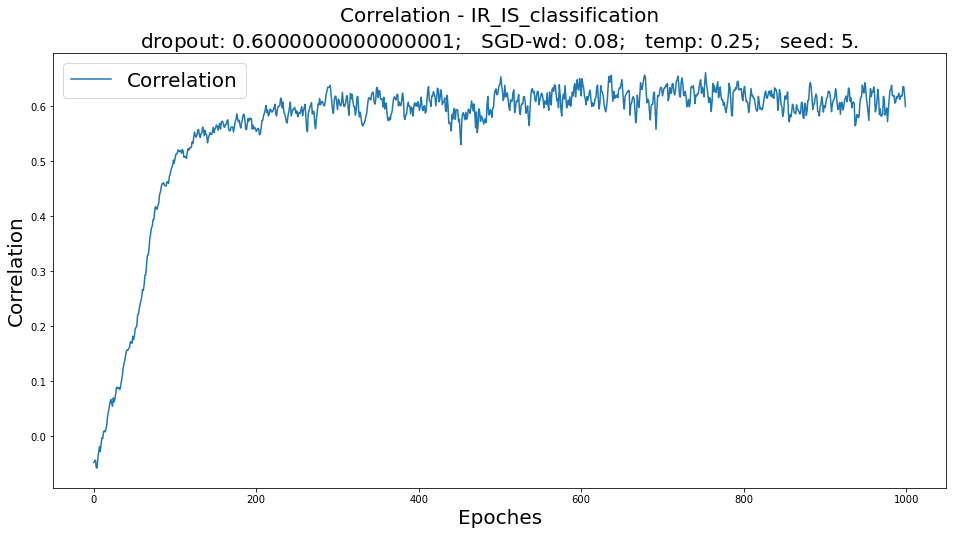

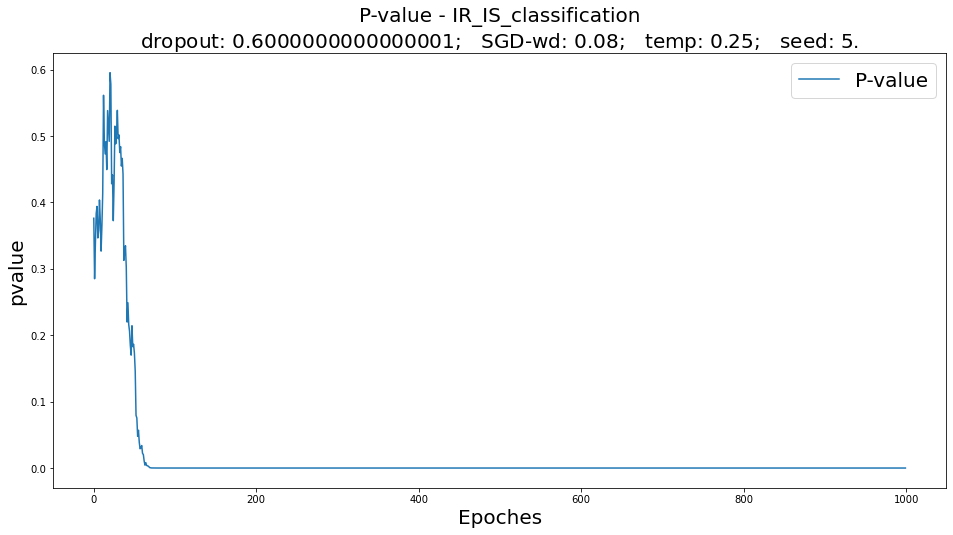


IR_IS_classification
n train: 382
n val: 81
n test: 84


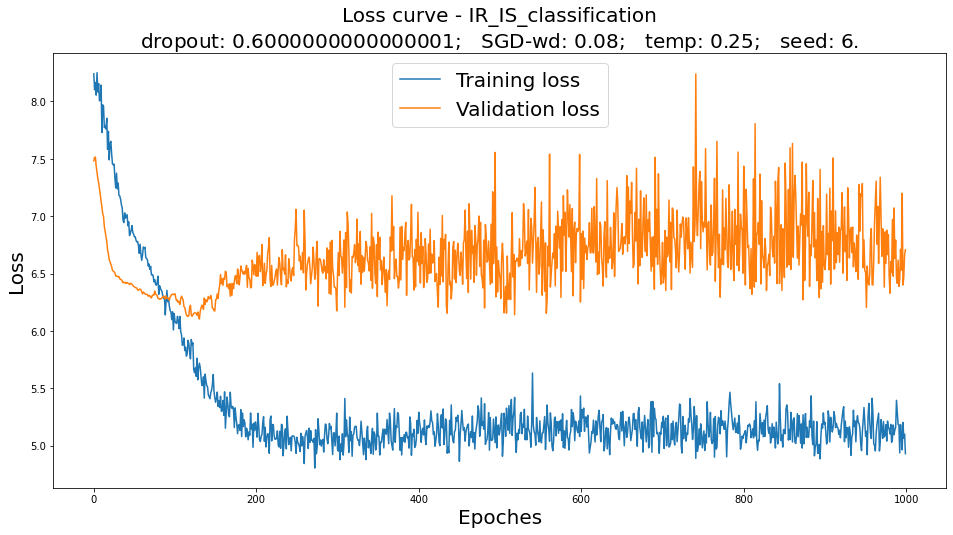

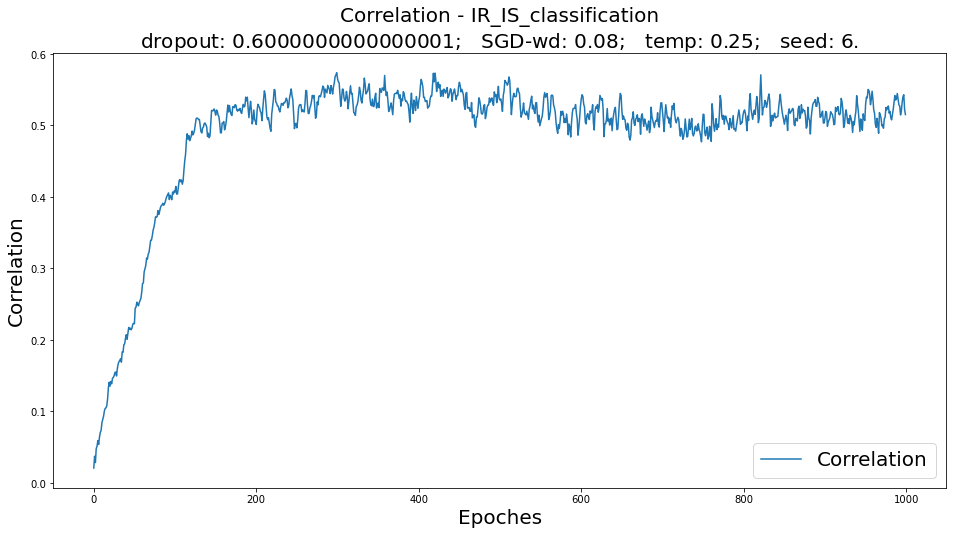

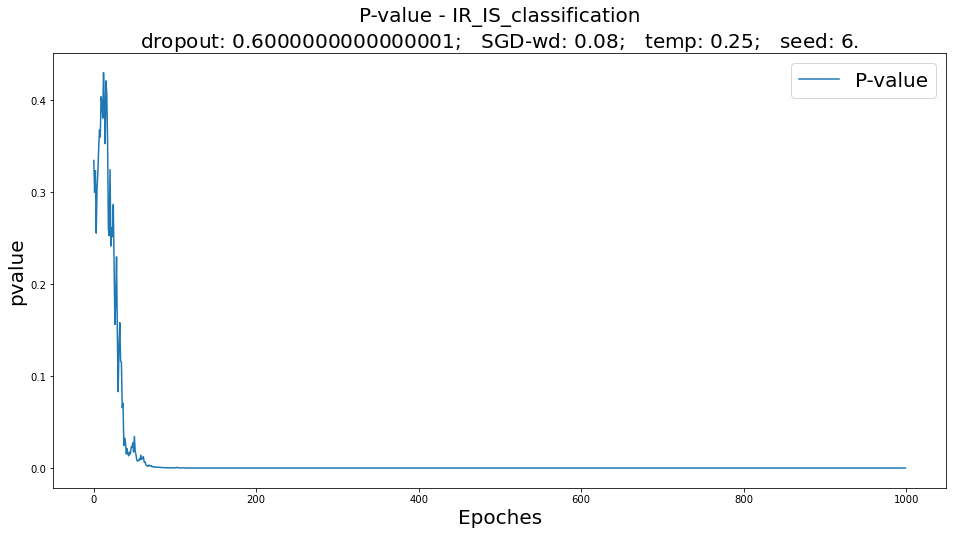


IR_IS_classification
n train: 382
n val: 81
n test: 84


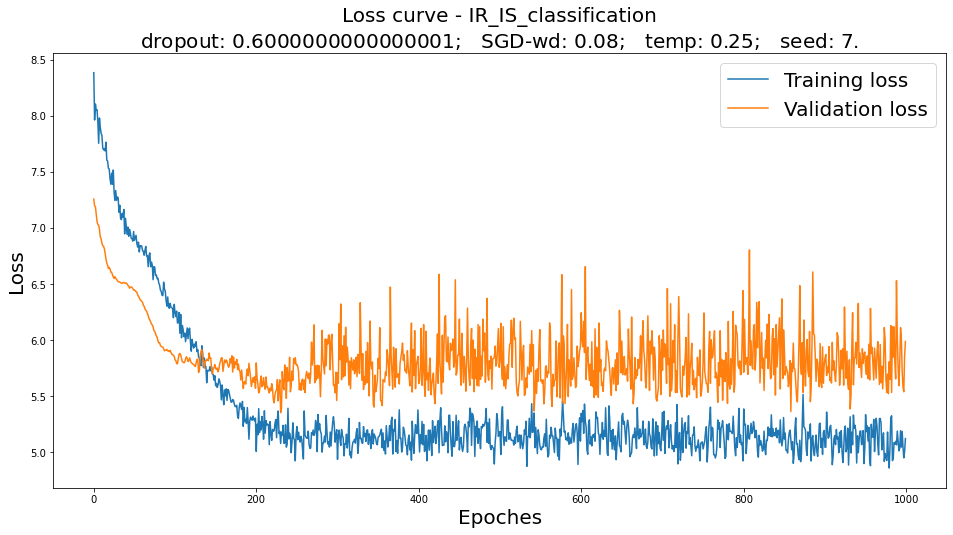

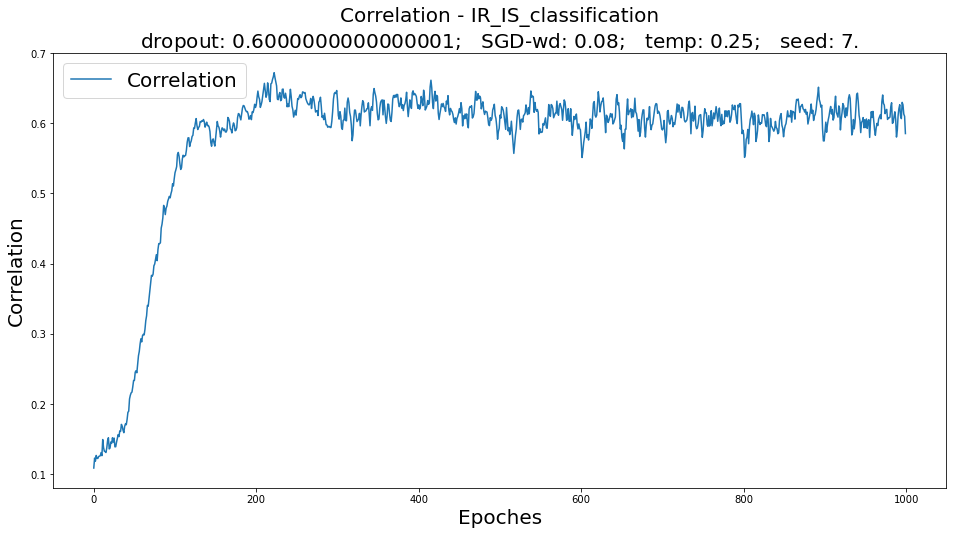

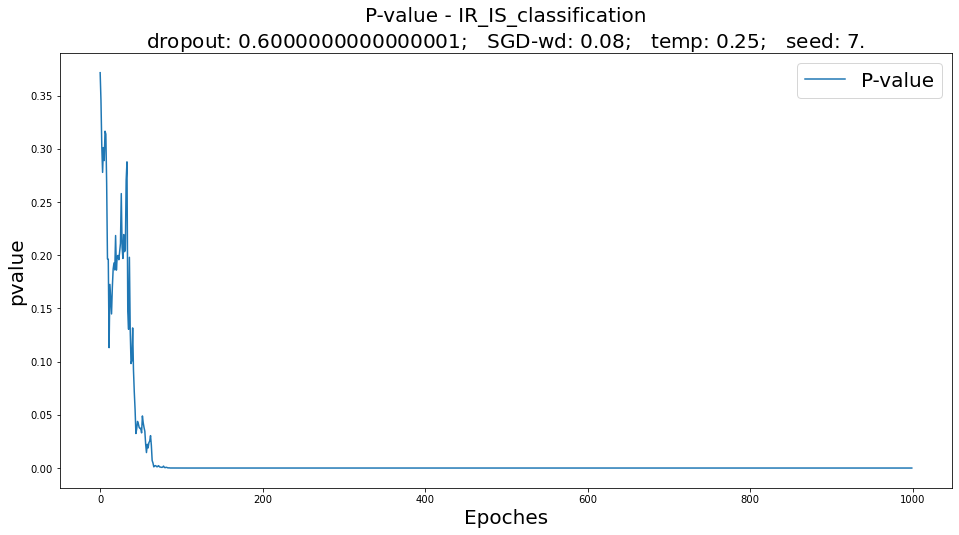


IR_IS_classification
n train: 382
n val: 81
n test: 84


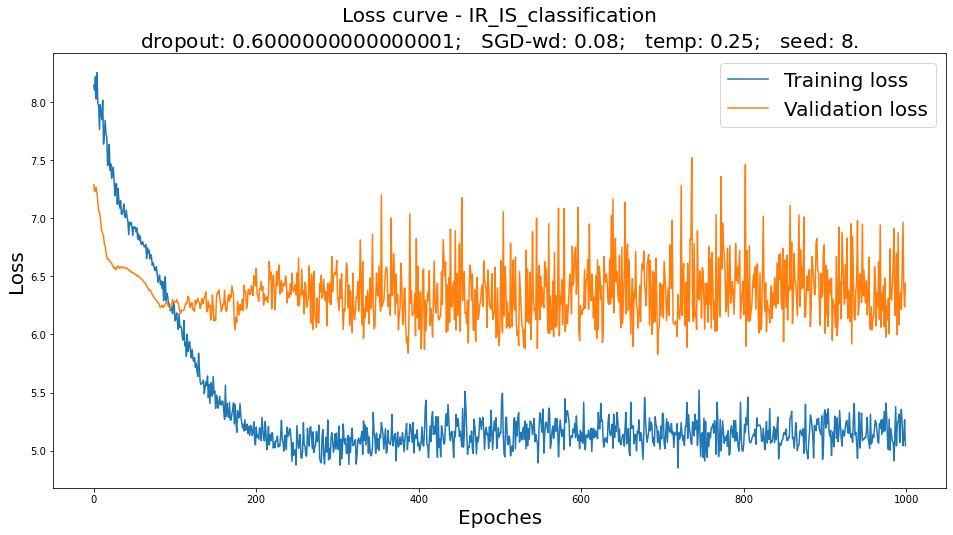

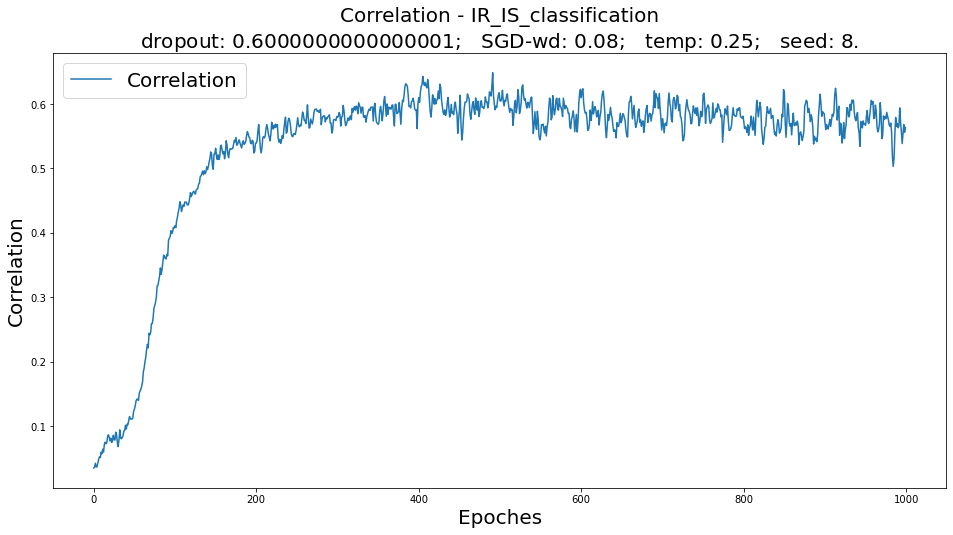

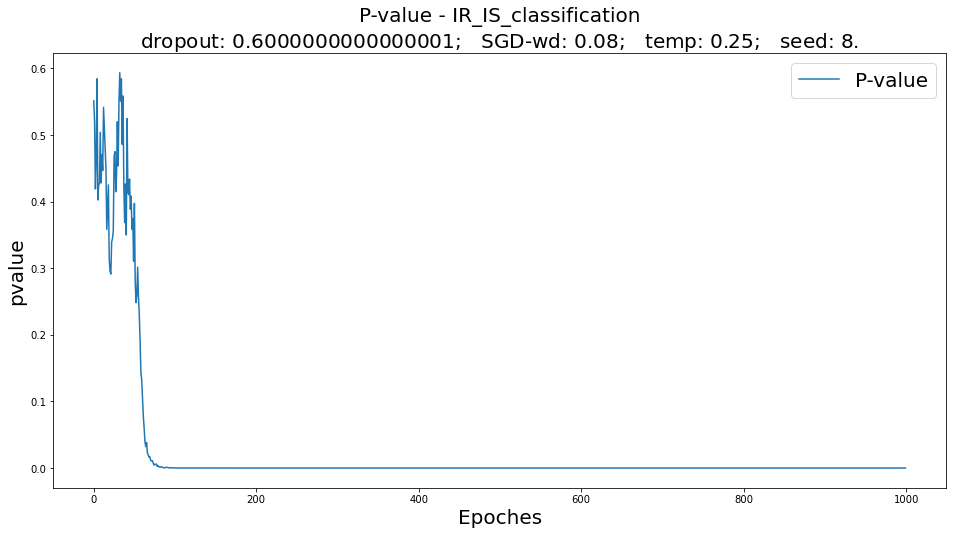


IR_IS_classification
n train: 382
n val: 81
n test: 84


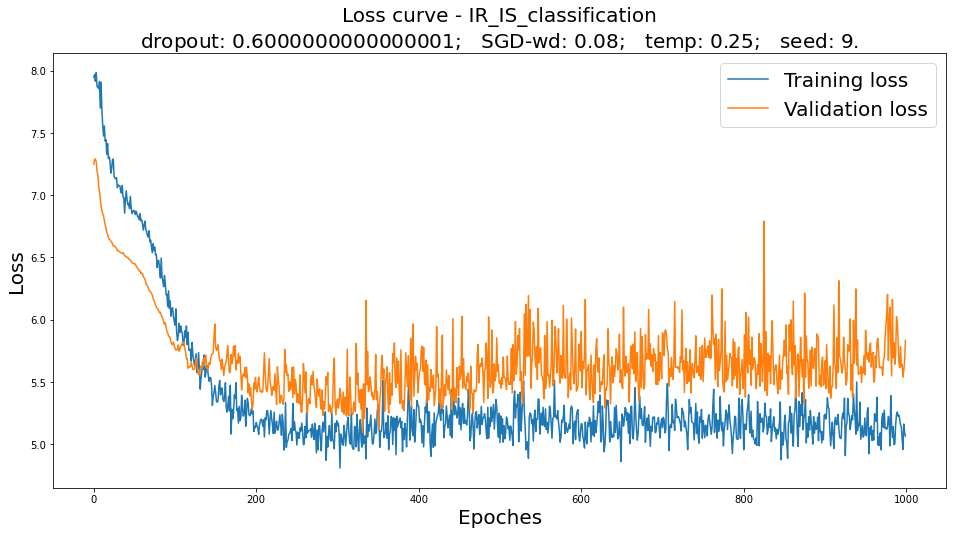

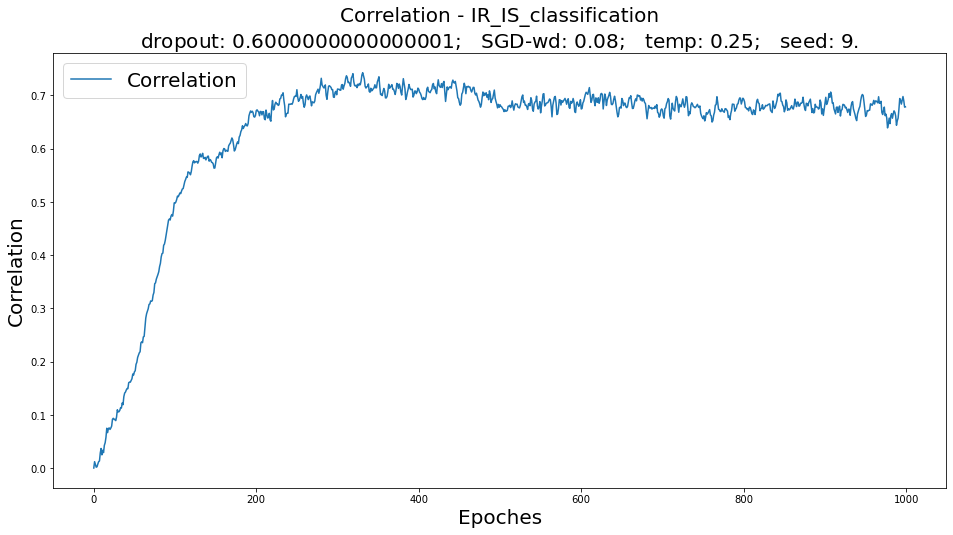

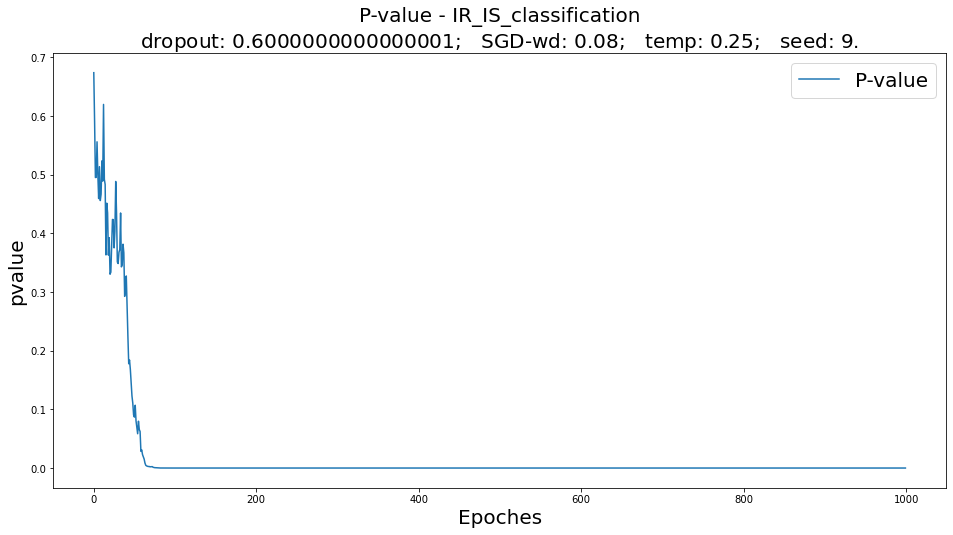


IR_IS_classification
n train: 382
n val: 81
n test: 84


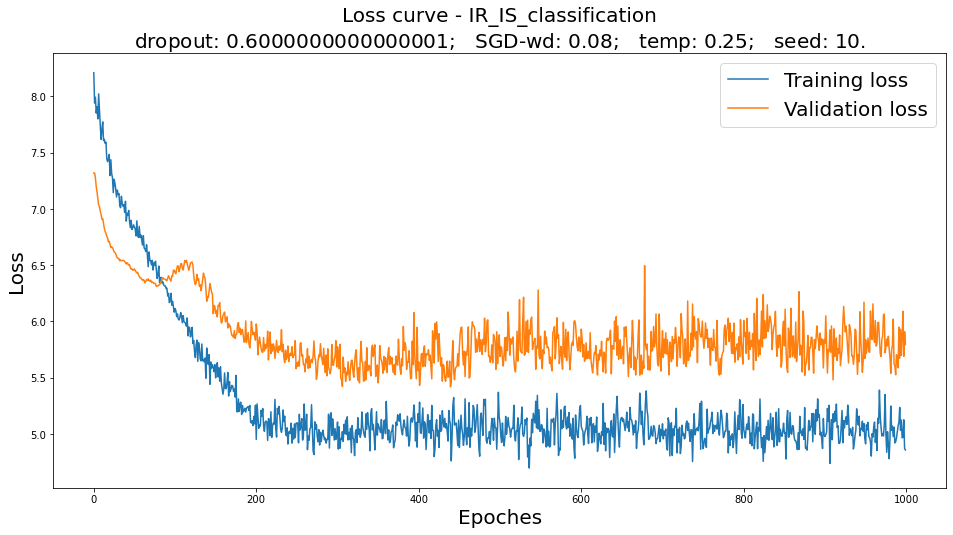

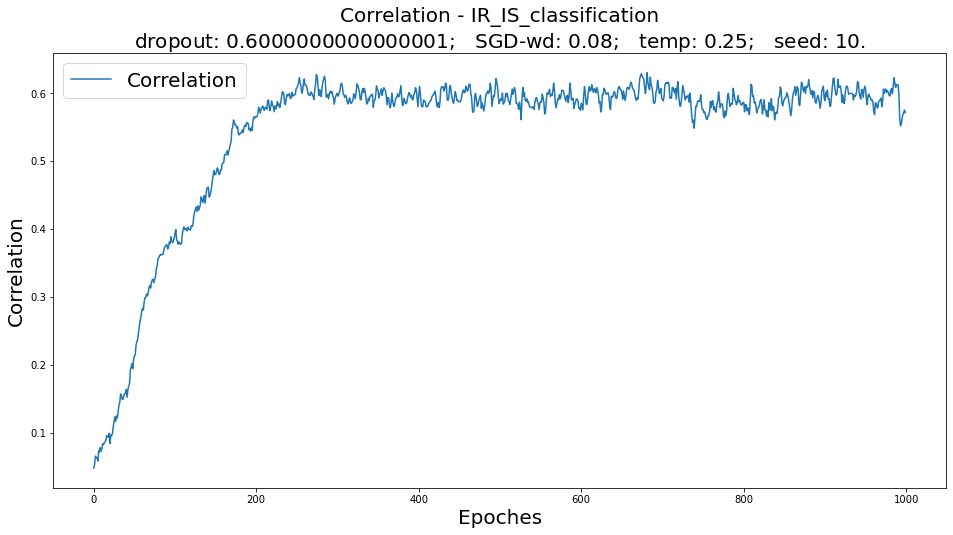

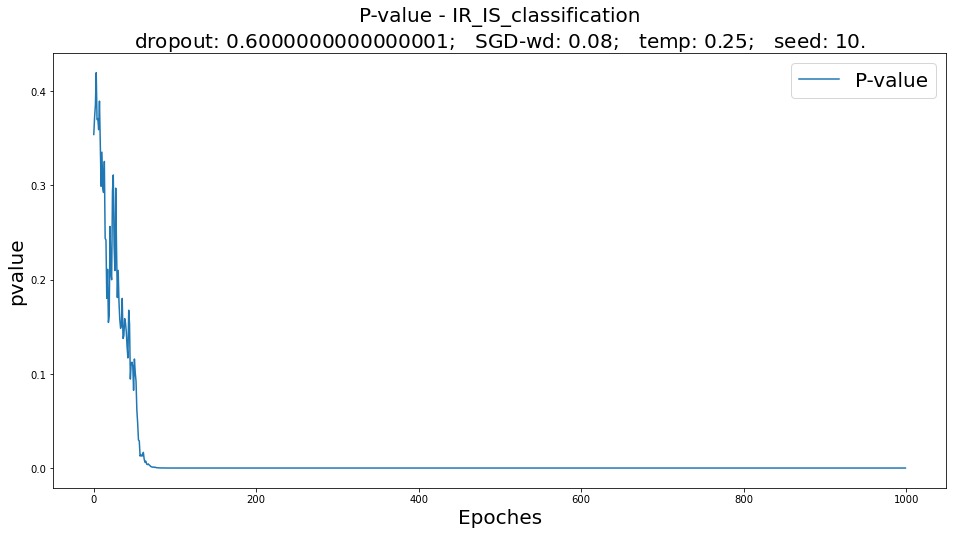


IR_IS_classification
n train: 382
n val: 81
n test: 84


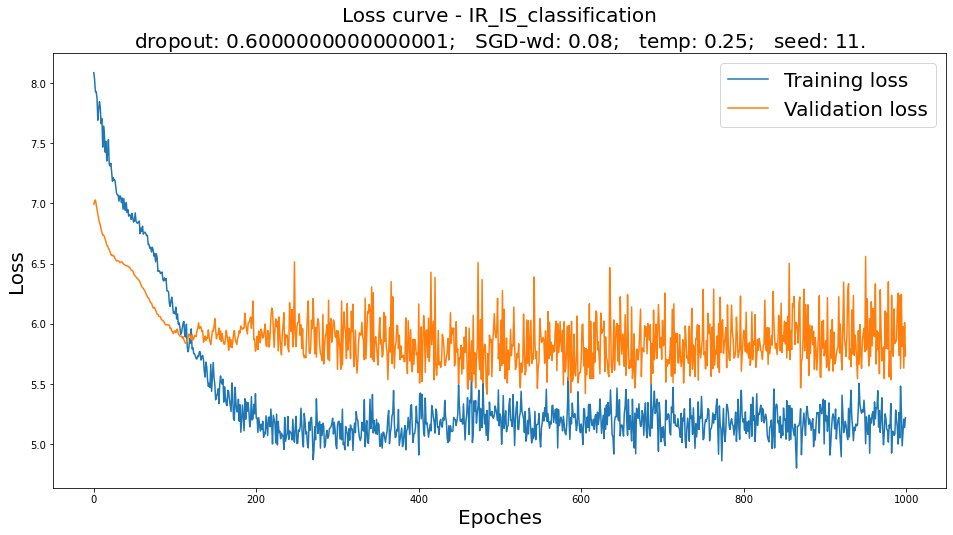

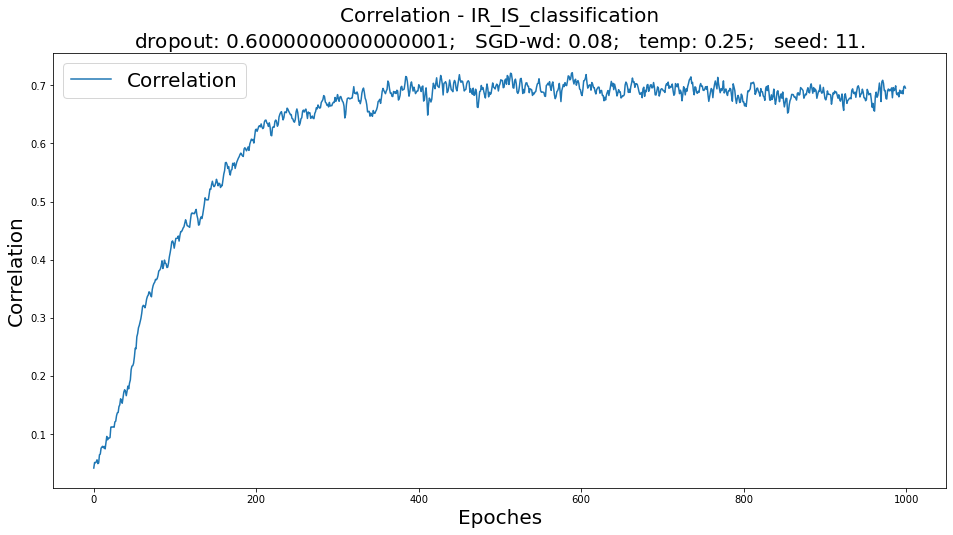

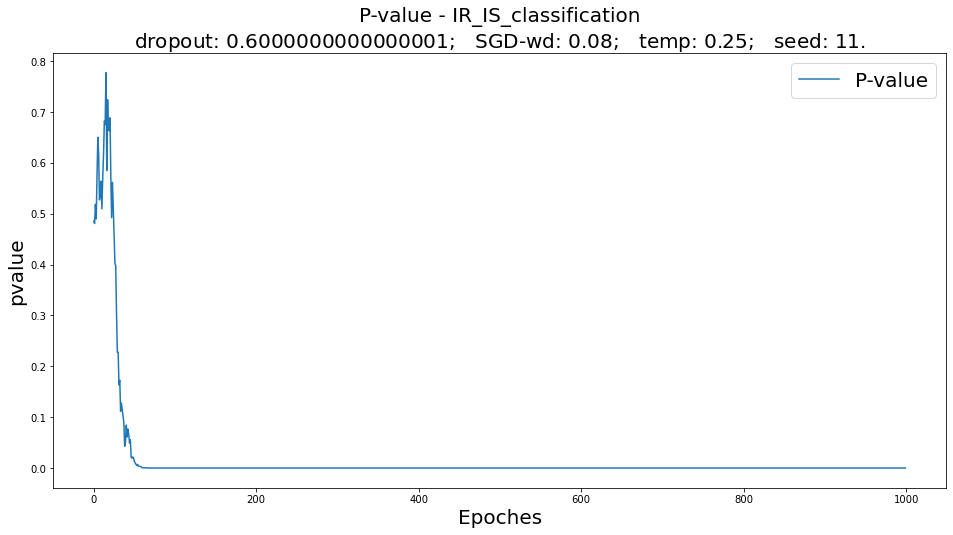


IR_IS_classification
n train: 382
n val: 81
n test: 84


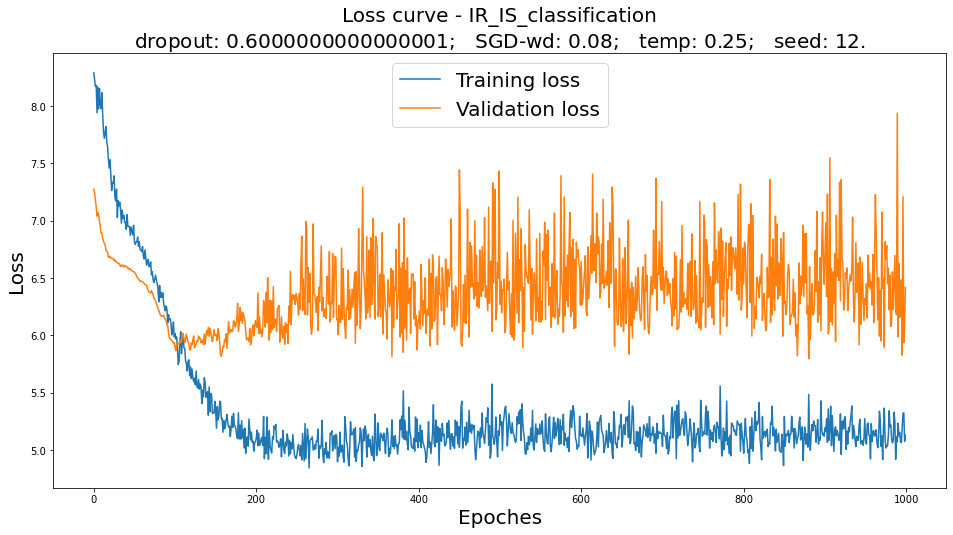

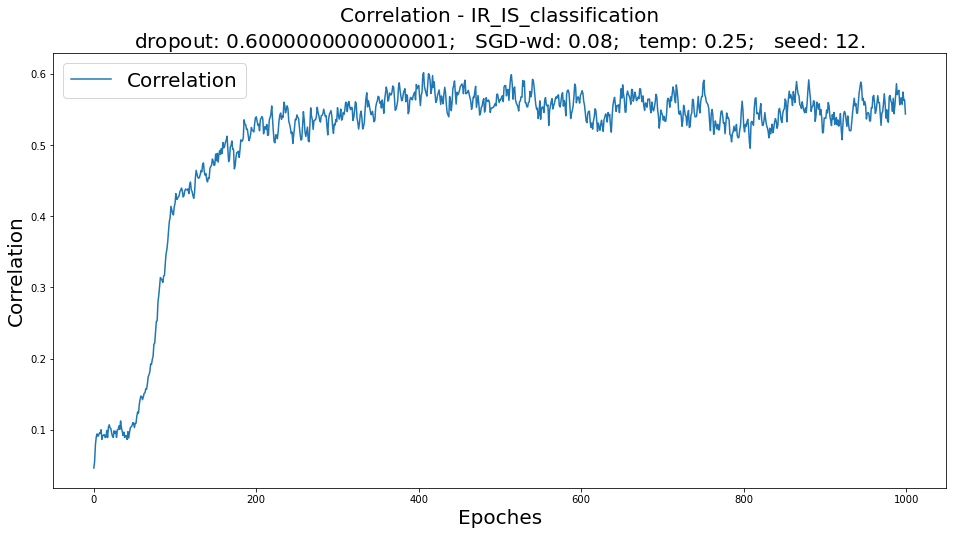

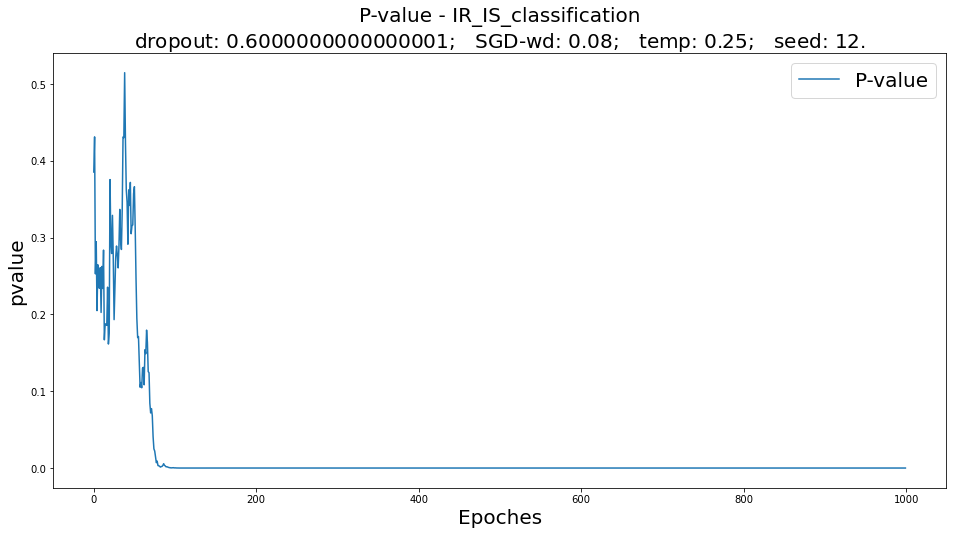


Sex
n train: 503
n val: 107
n test: 110


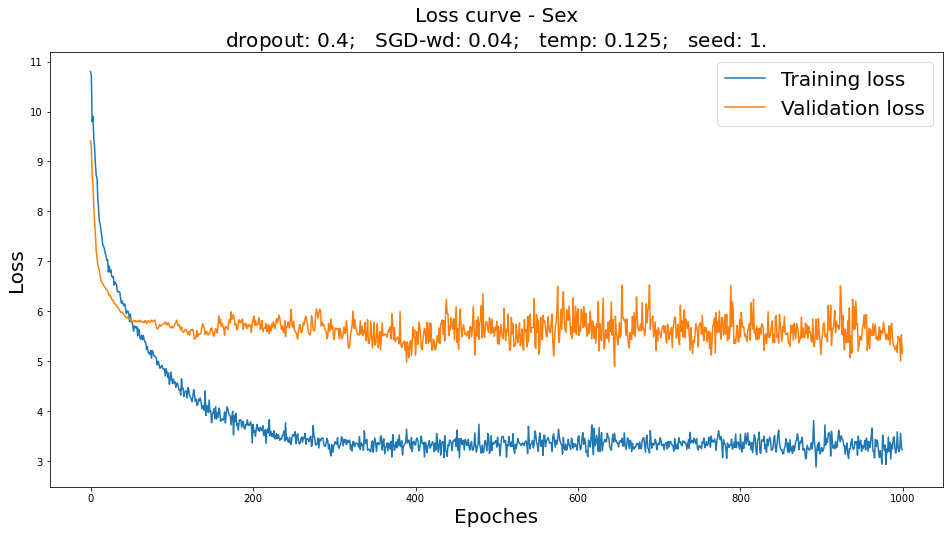

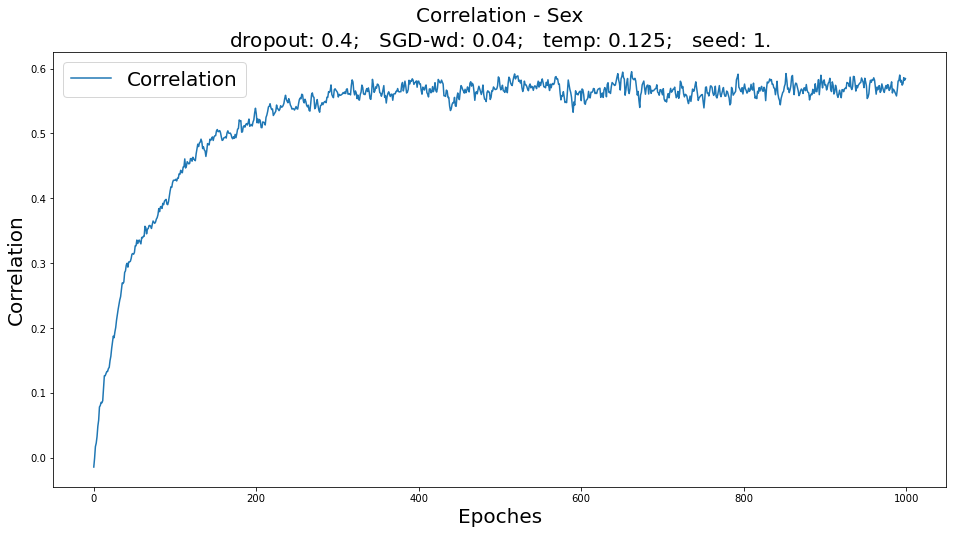

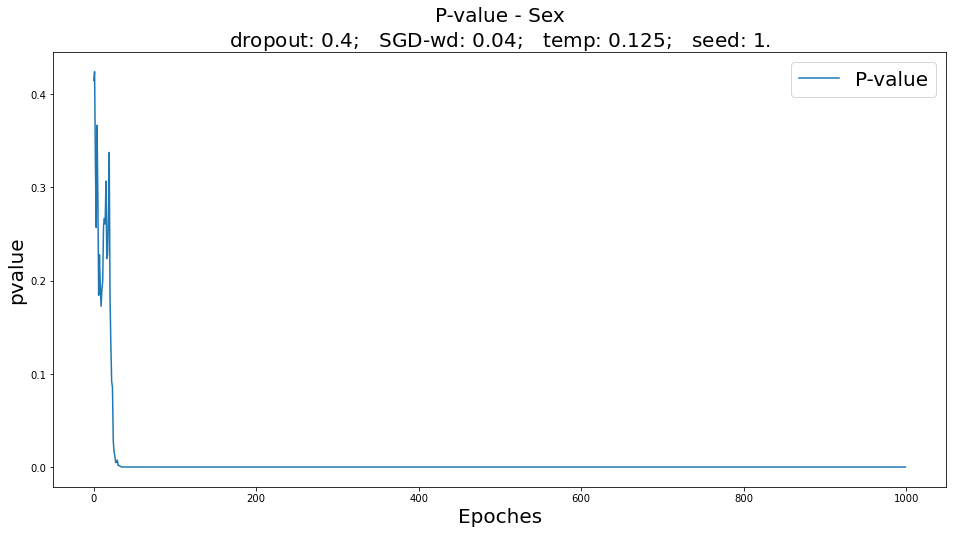


Sex
n train: 503
n val: 107
n test: 110


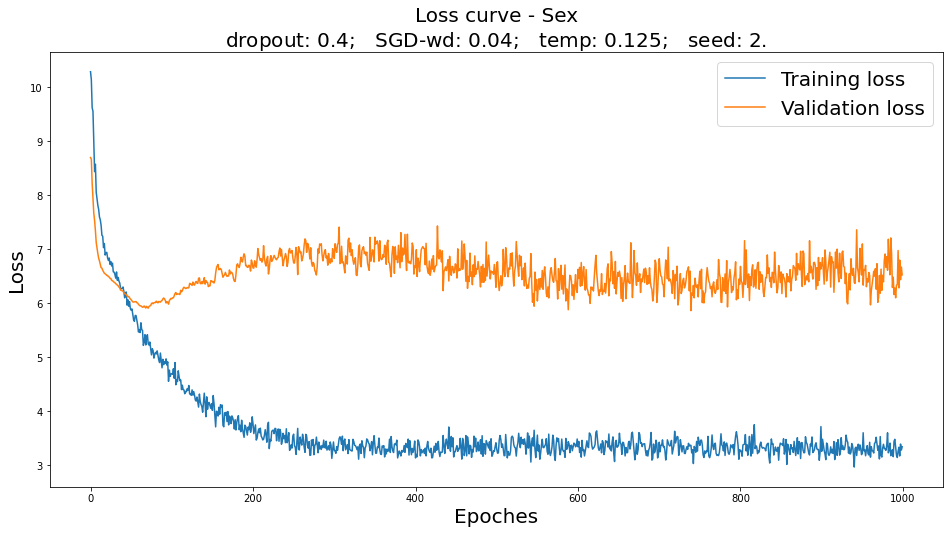

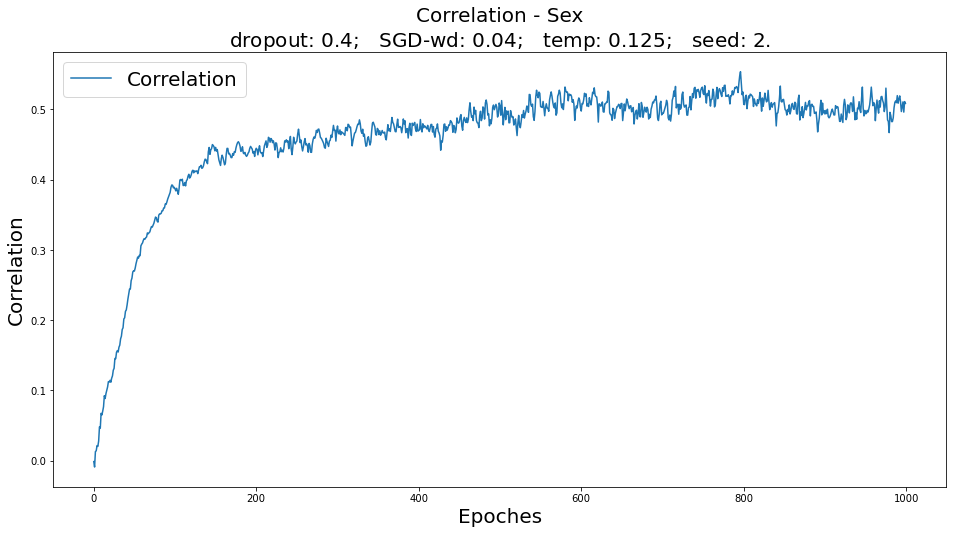

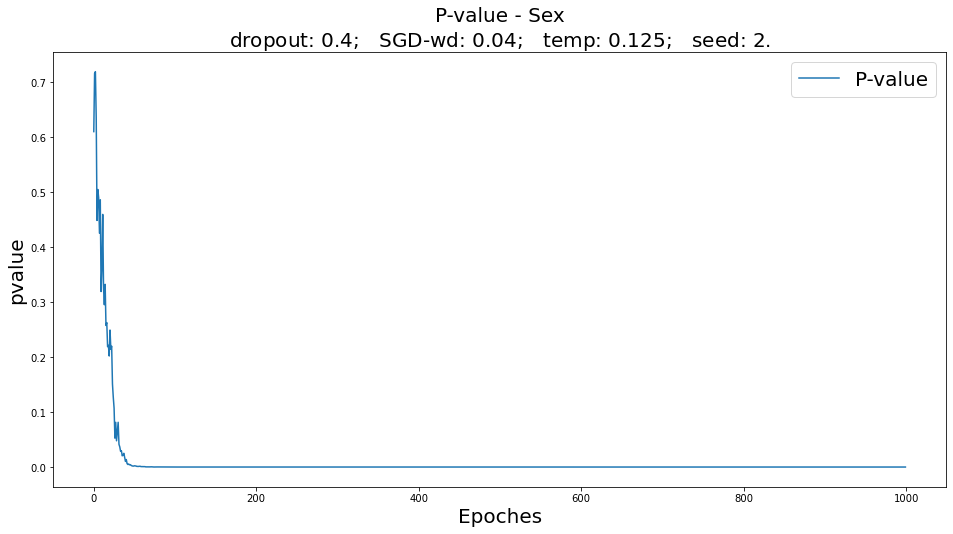


Sex
n train: 503
n val: 107
n test: 110


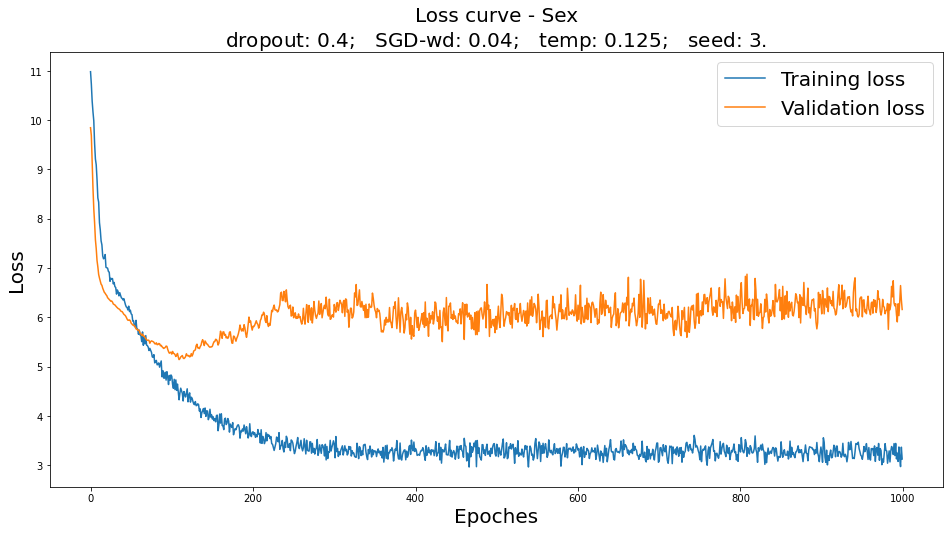

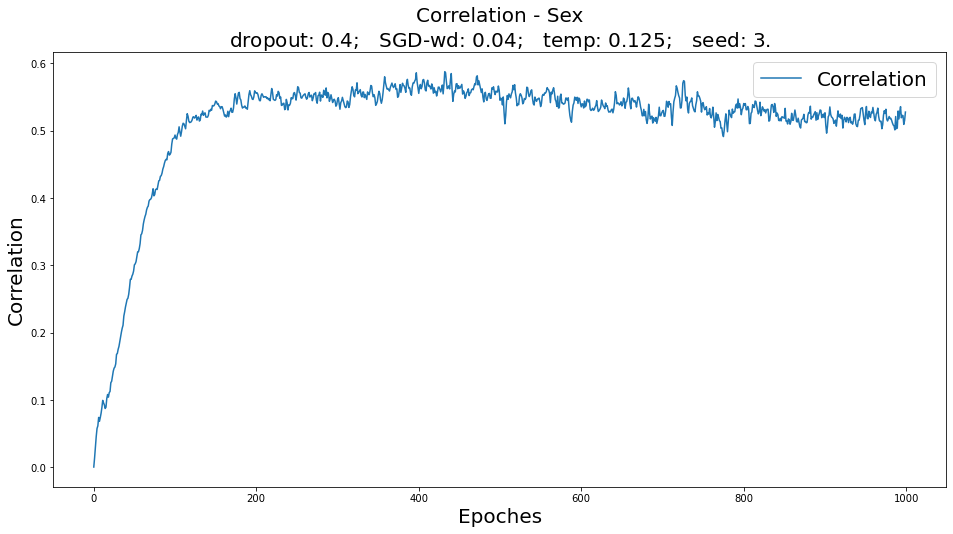

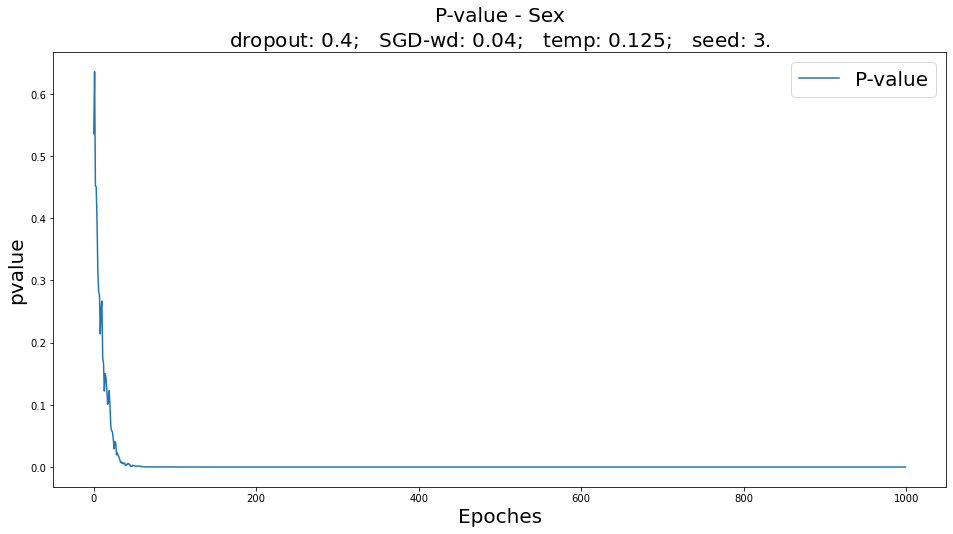


Sex
n train: 503
n val: 107
n test: 110


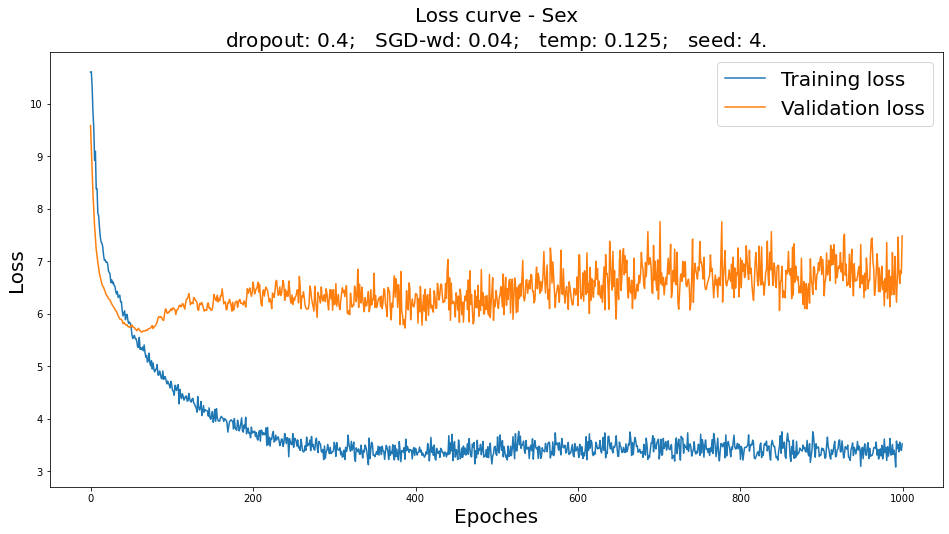

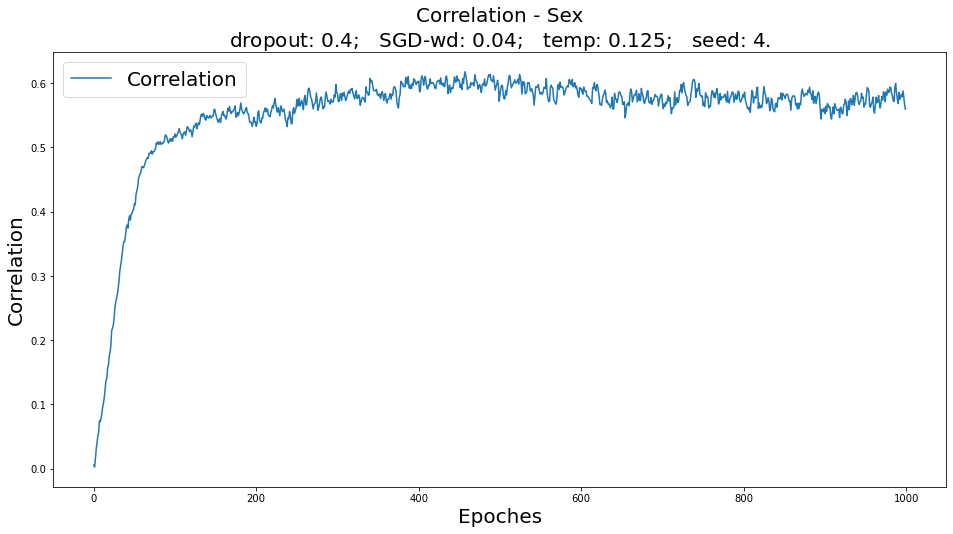

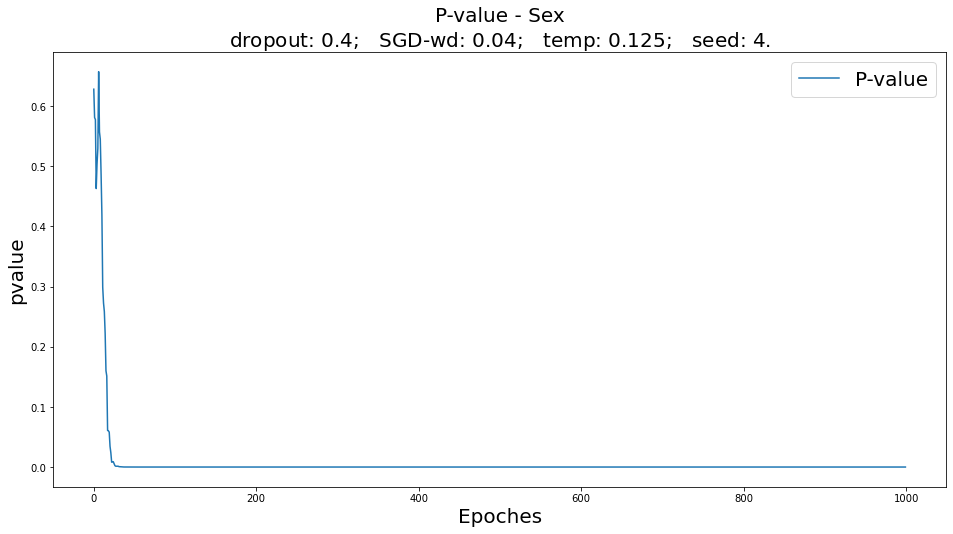


Sex
n train: 503
n val: 107
n test: 110


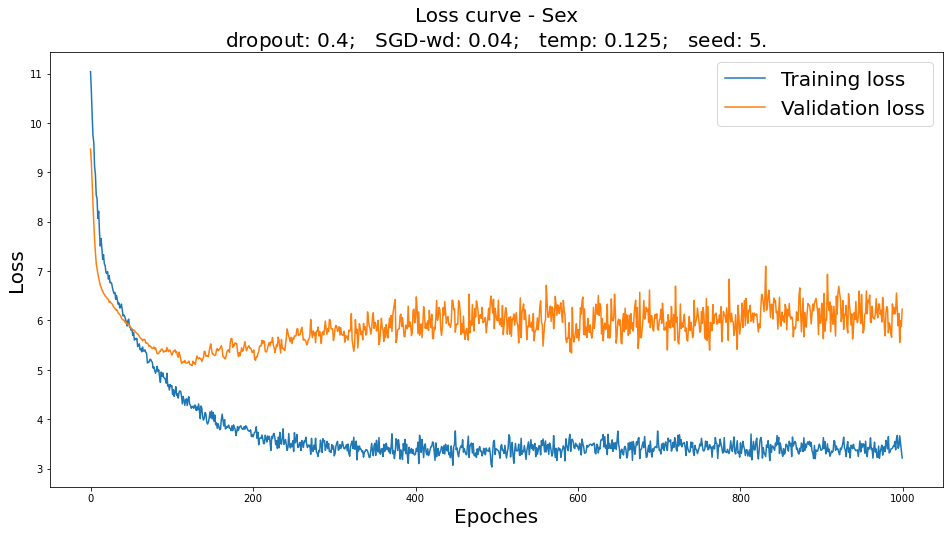

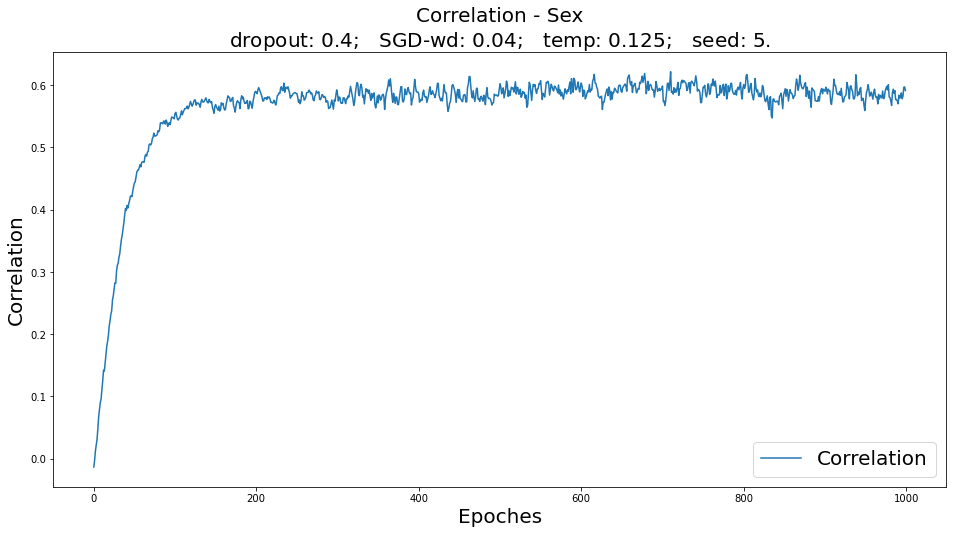

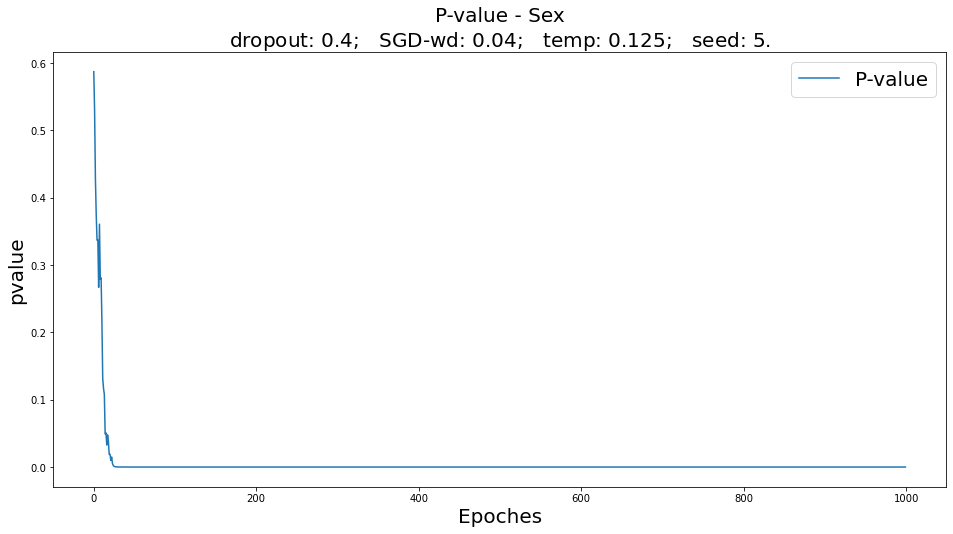


Sex
n train: 503
n val: 107
n test: 110


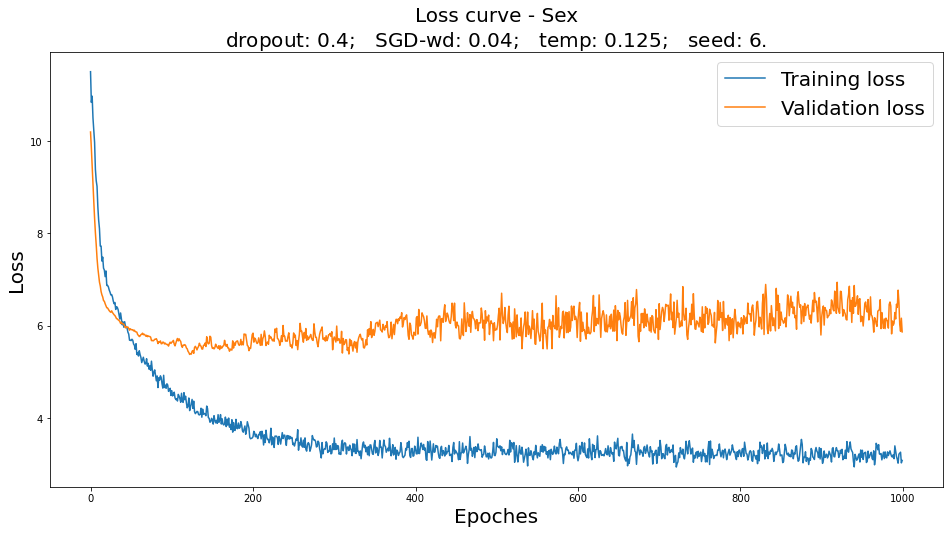

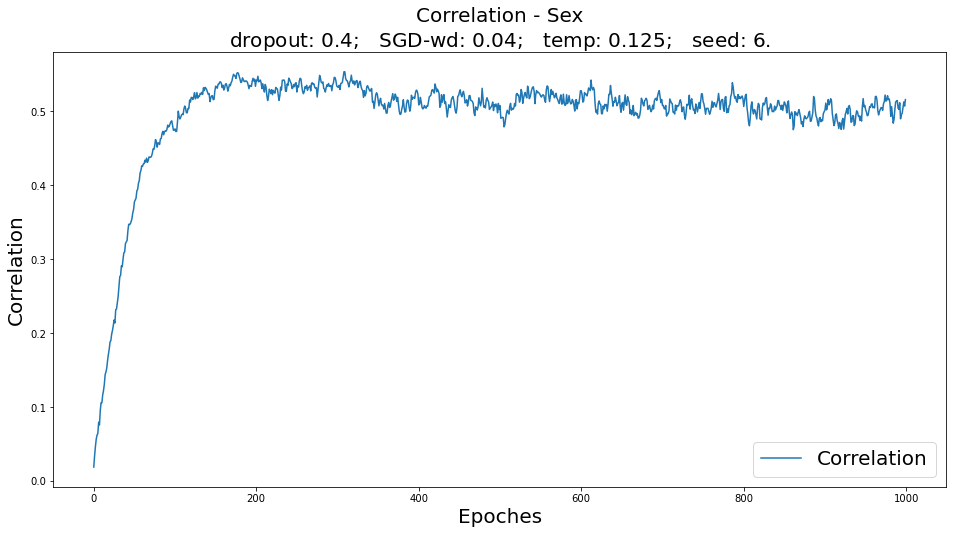

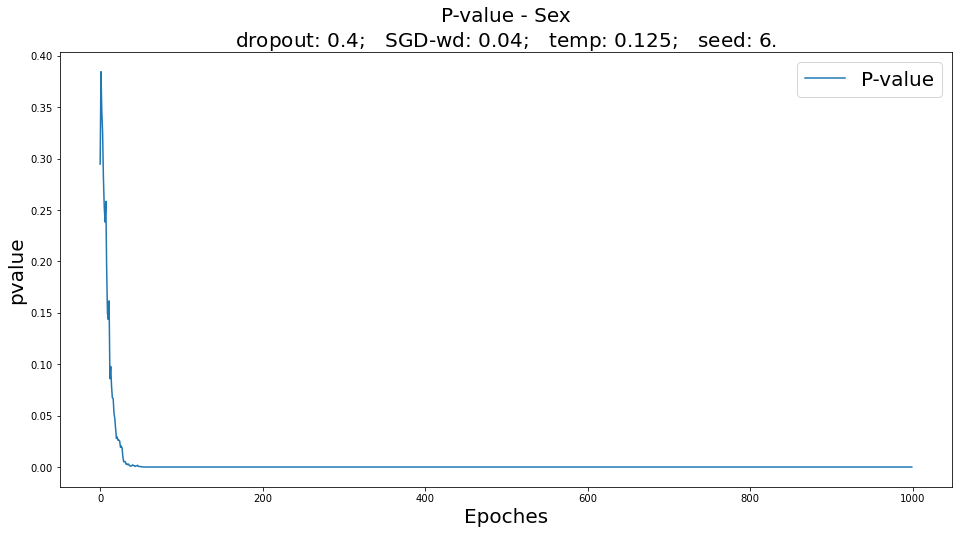


Sex
n train: 503
n val: 107
n test: 110


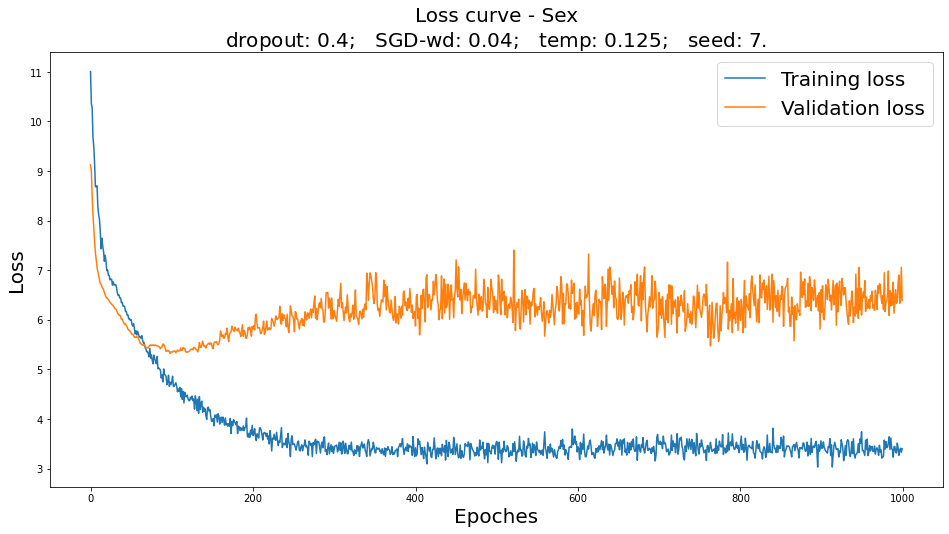

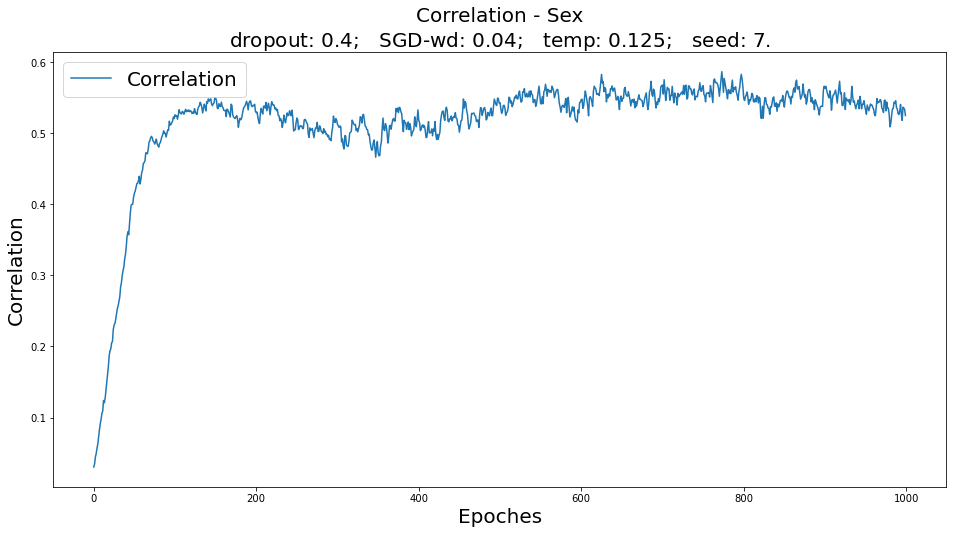

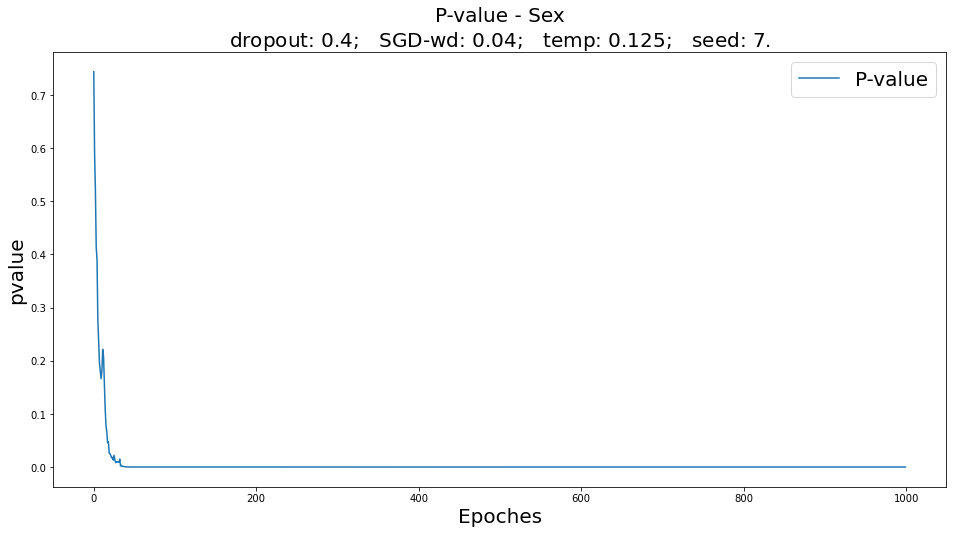


Sex
n train: 503
n val: 107
n test: 110


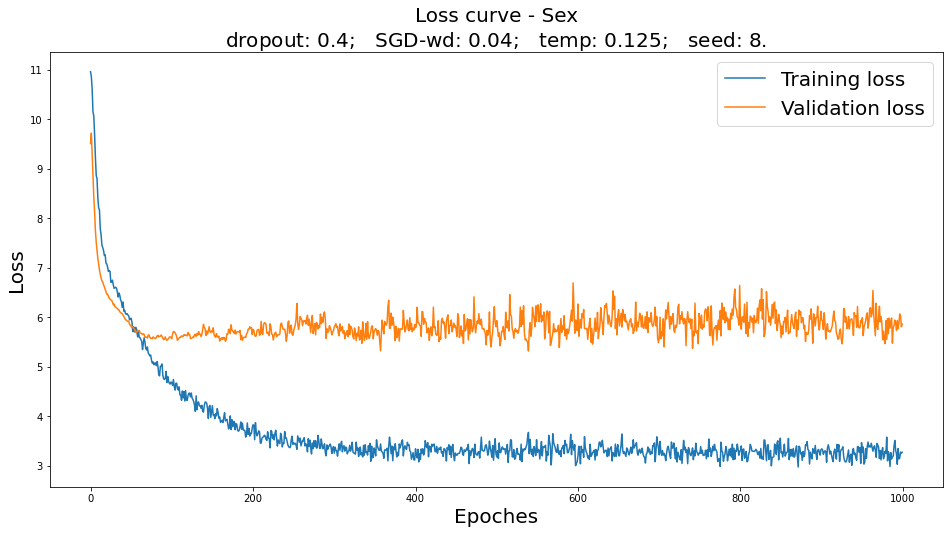

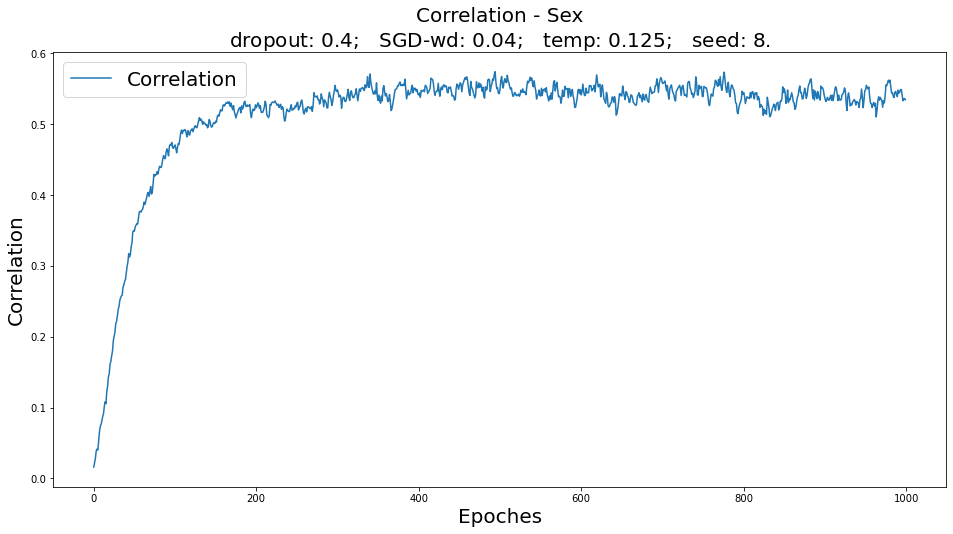

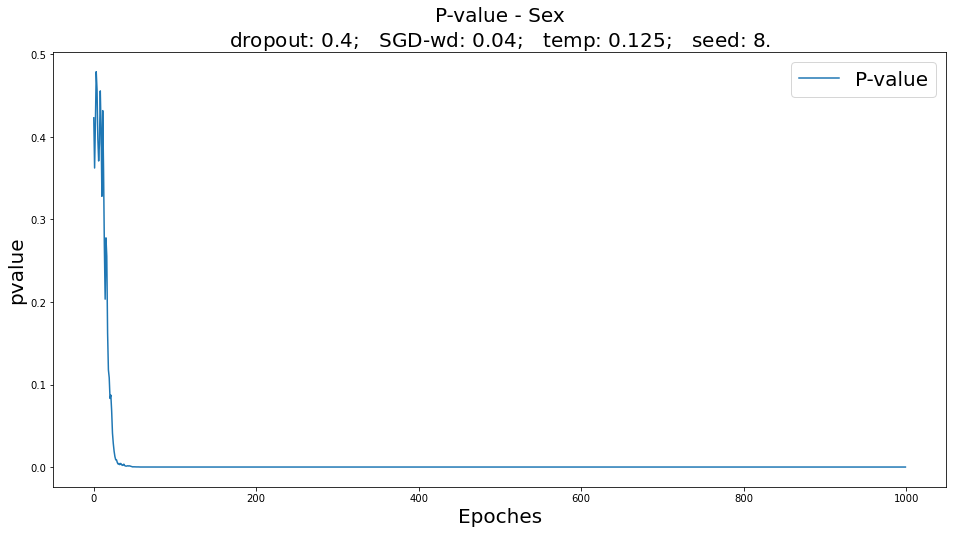


Sex
n train: 503
n val: 107
n test: 110


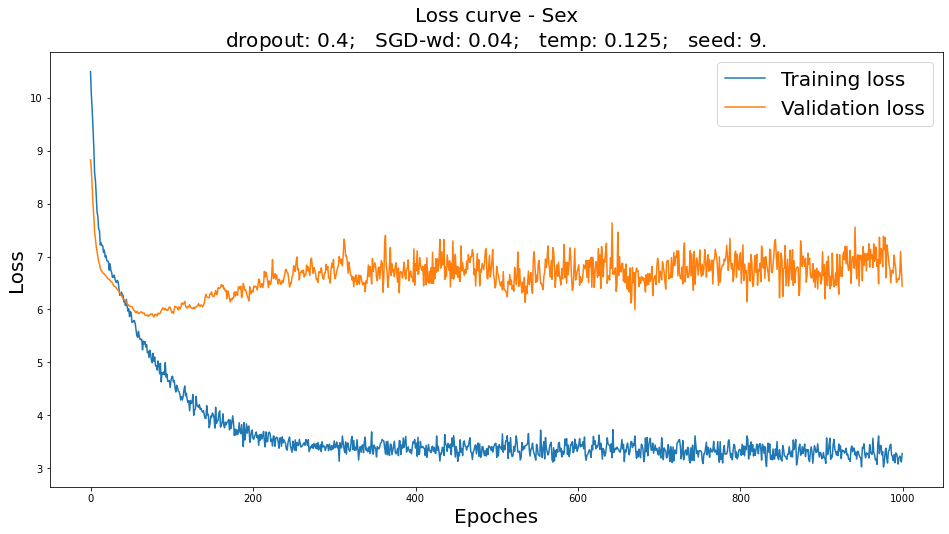

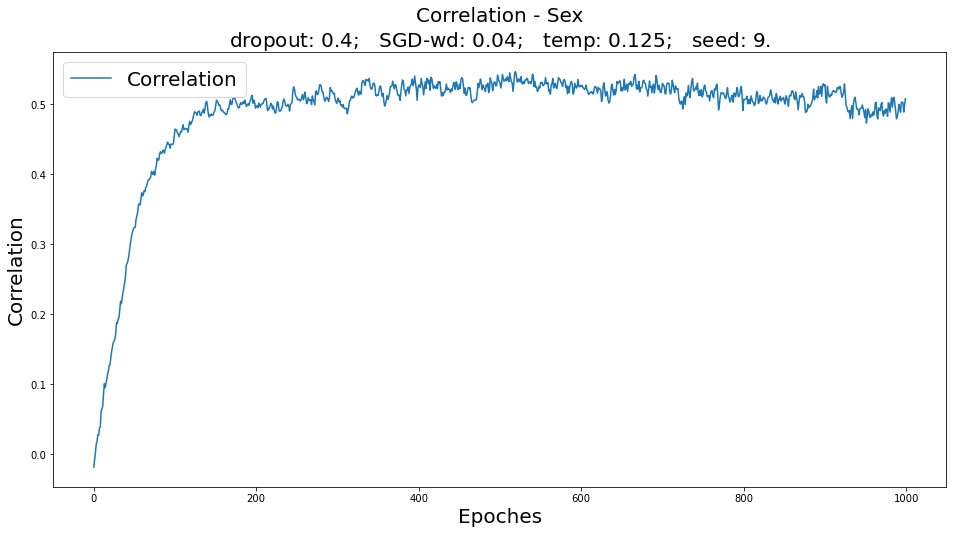

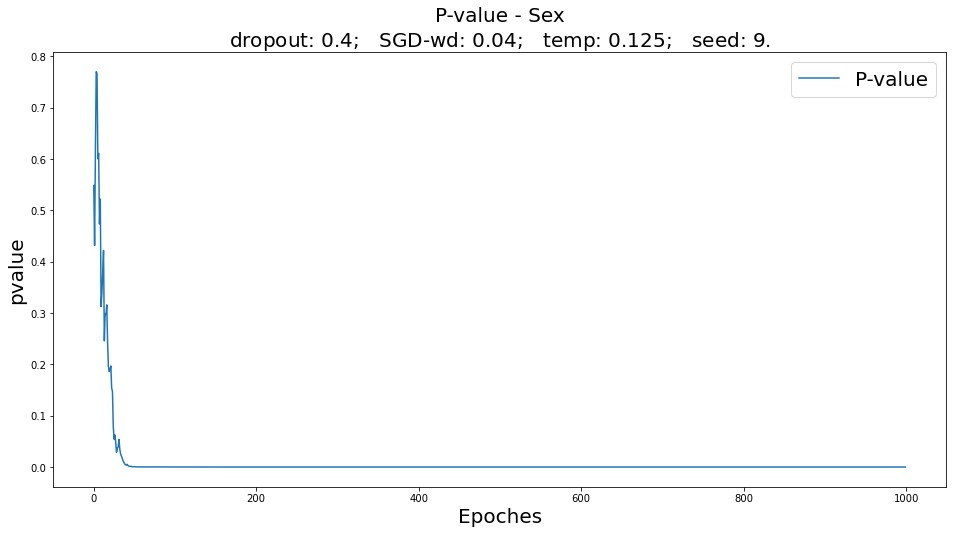


Sex
n train: 503
n val: 107
n test: 110


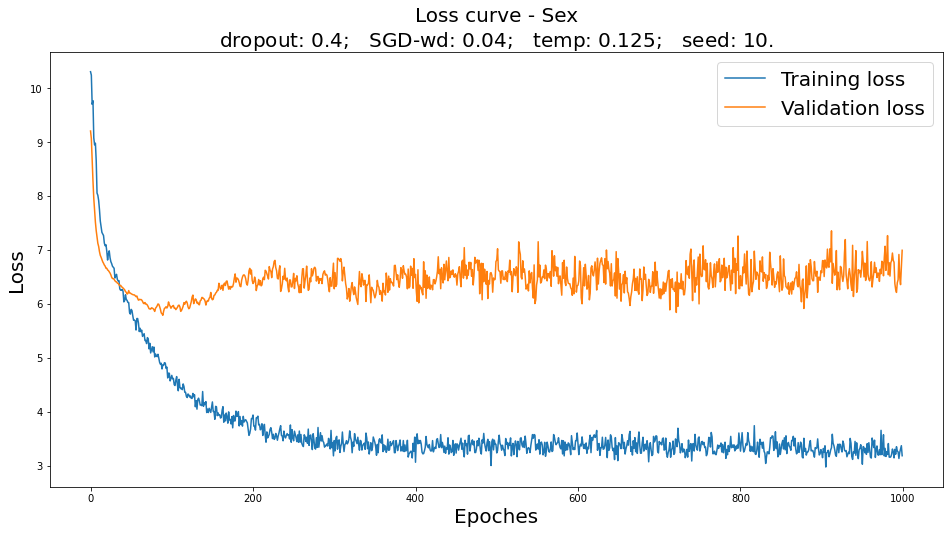

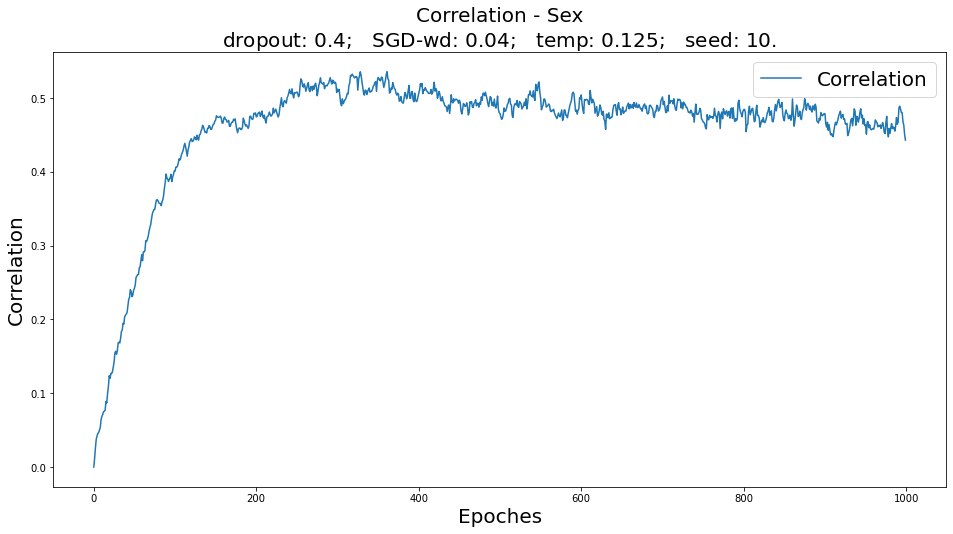

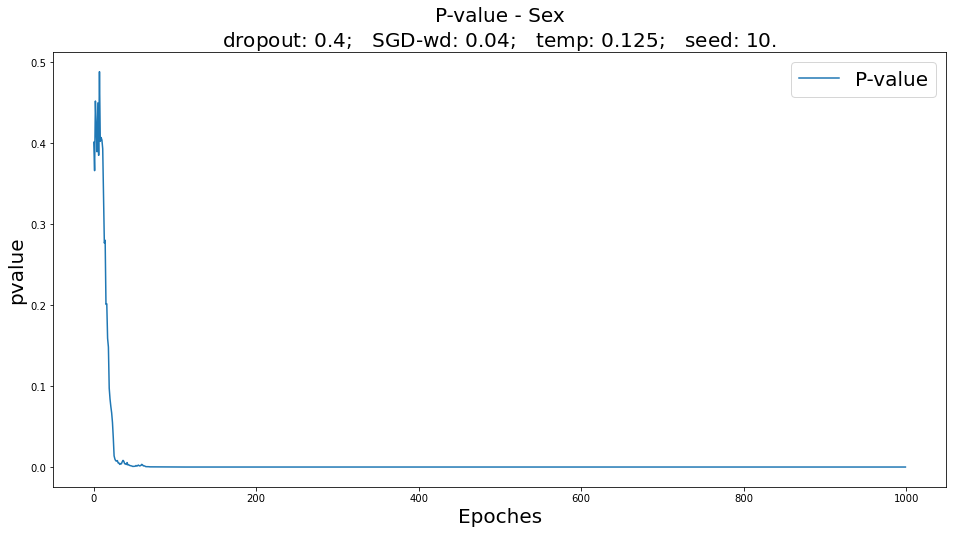


Sex
n train: 503
n val: 107
n test: 110


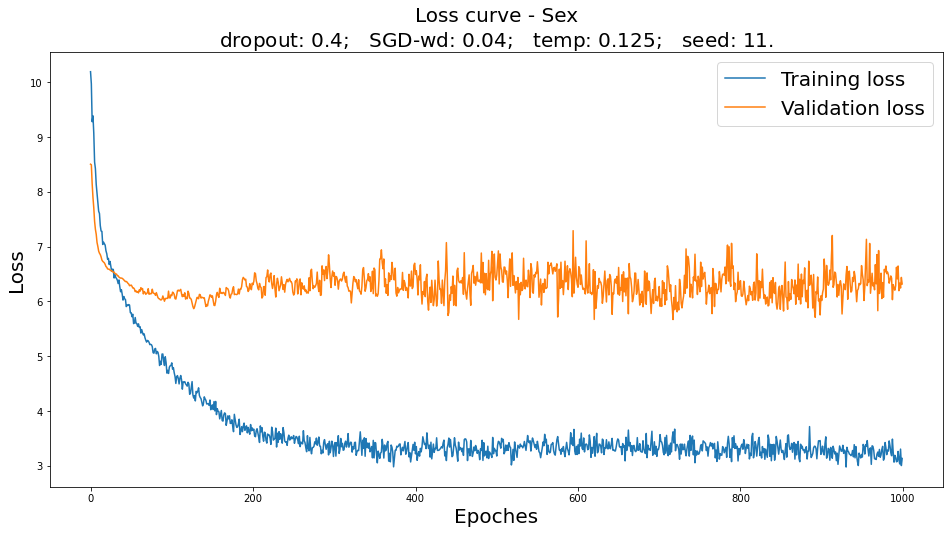

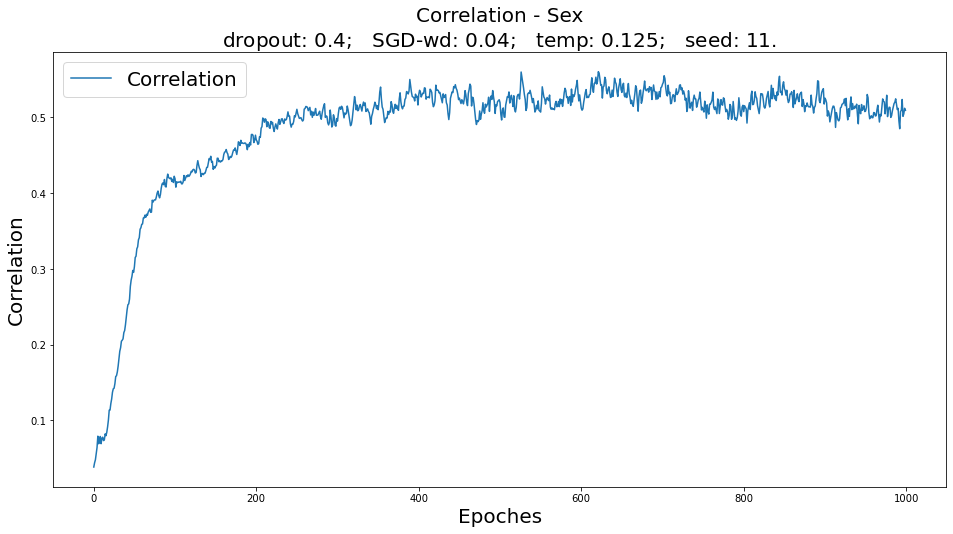

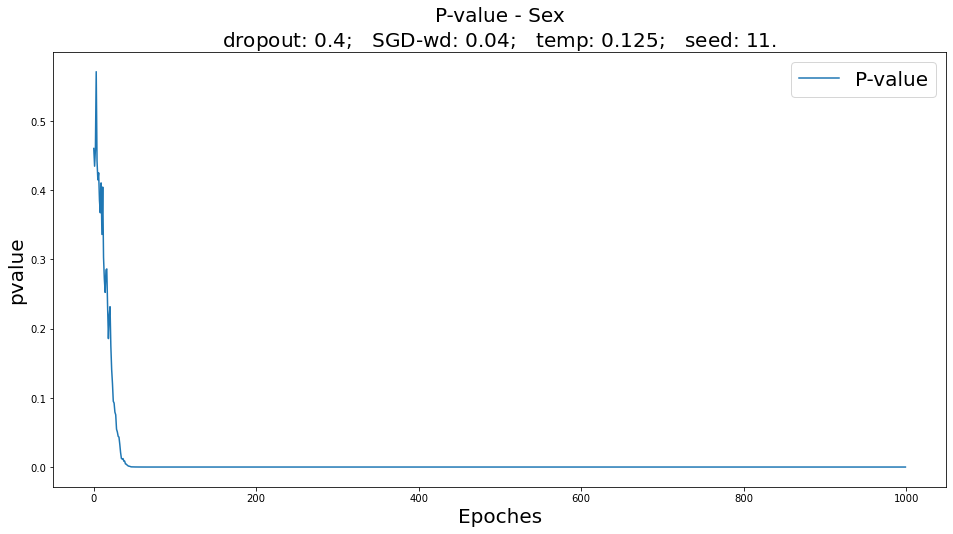


Sex
n train: 503
n val: 107
n test: 110


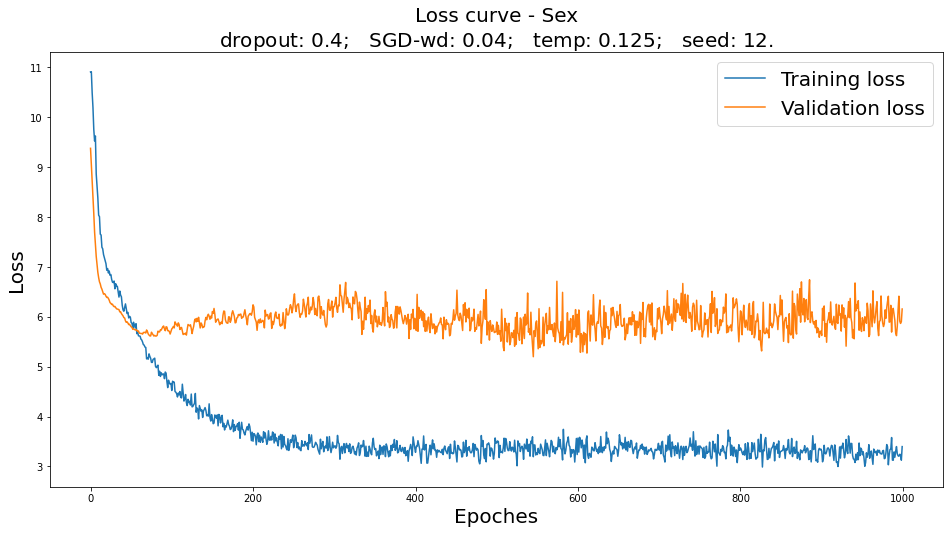

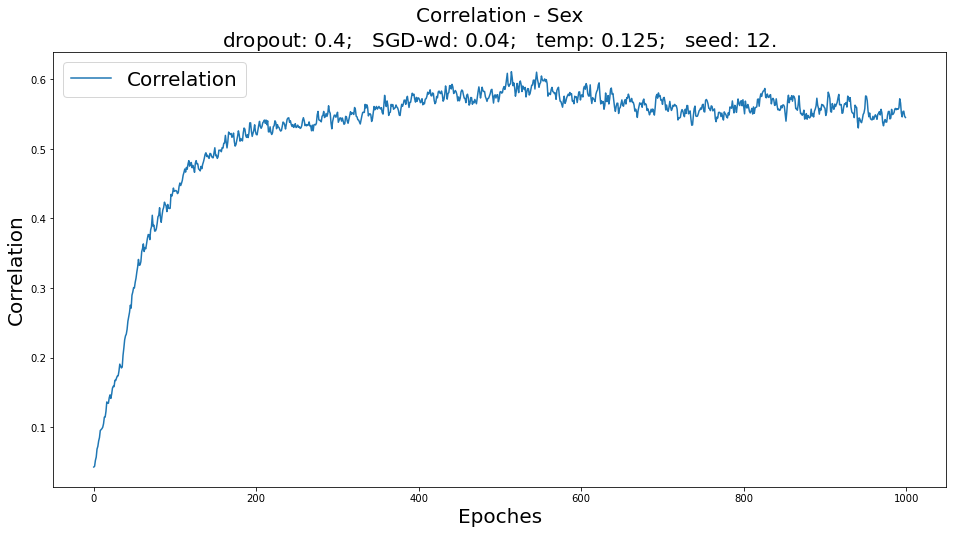

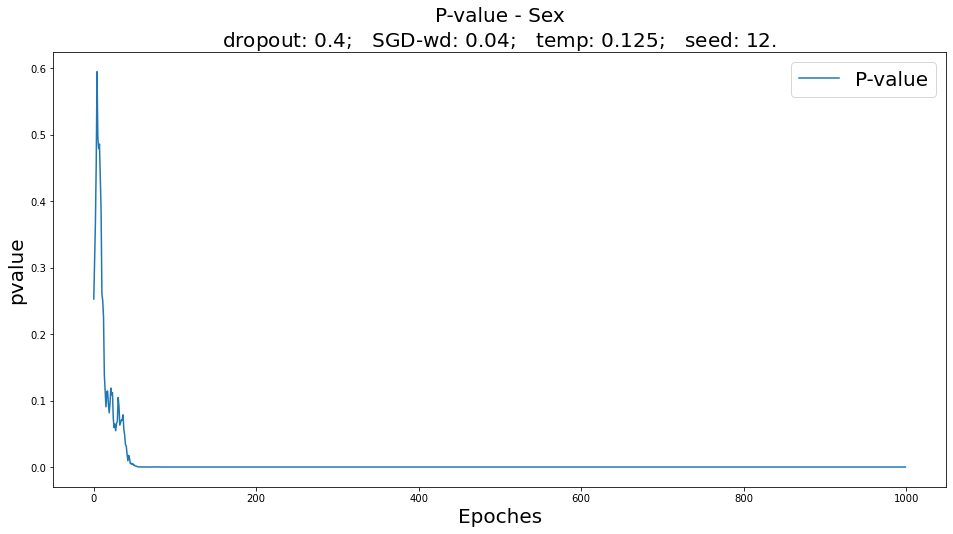


Race
n train: 501
n val: 105
n test: 112


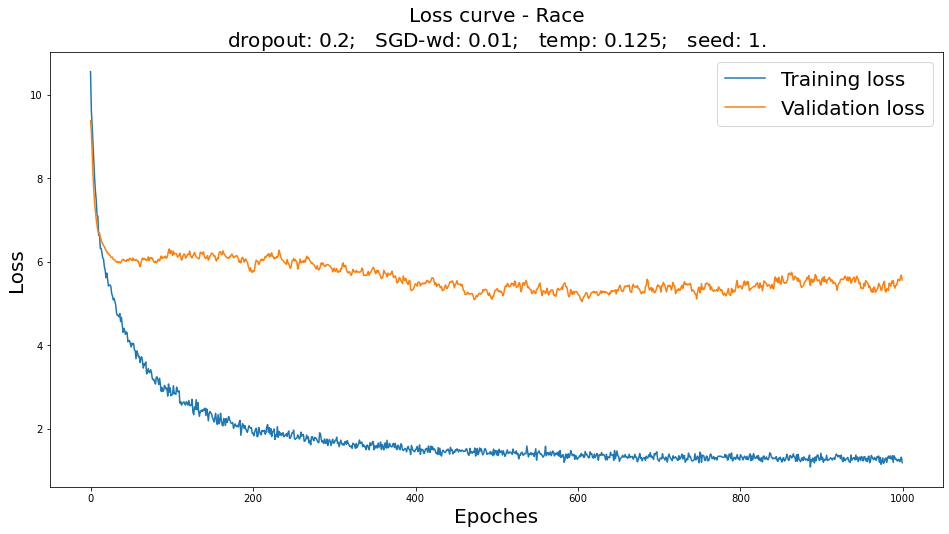

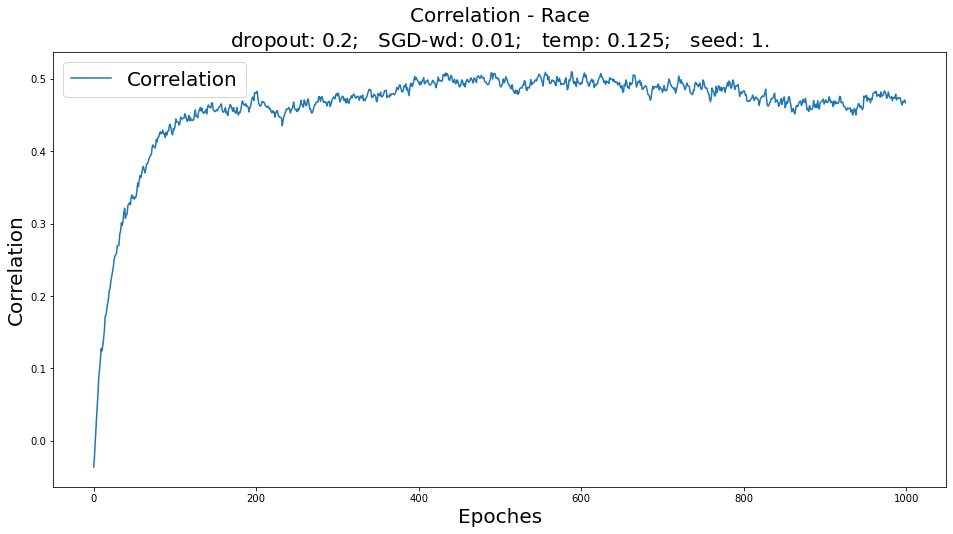

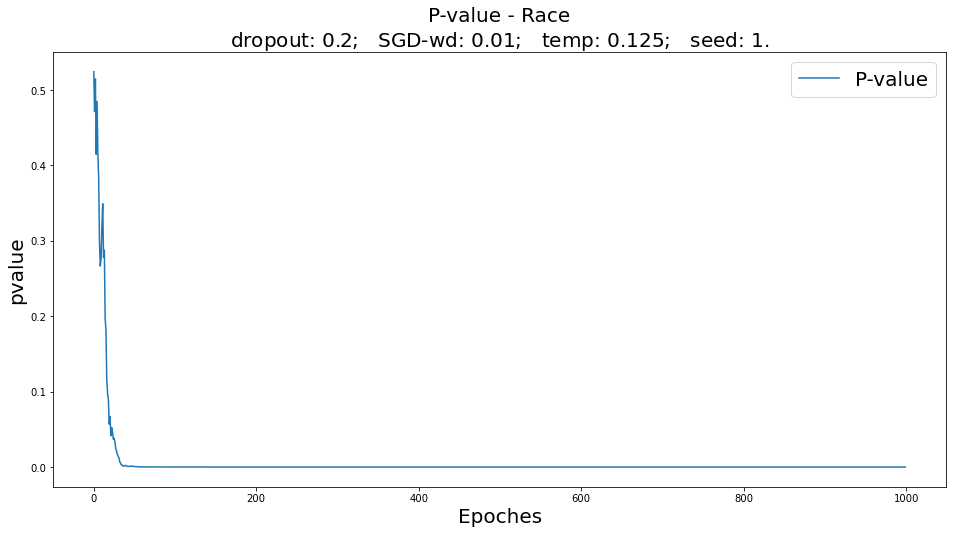


Race
n train: 501
n val: 105
n test: 112


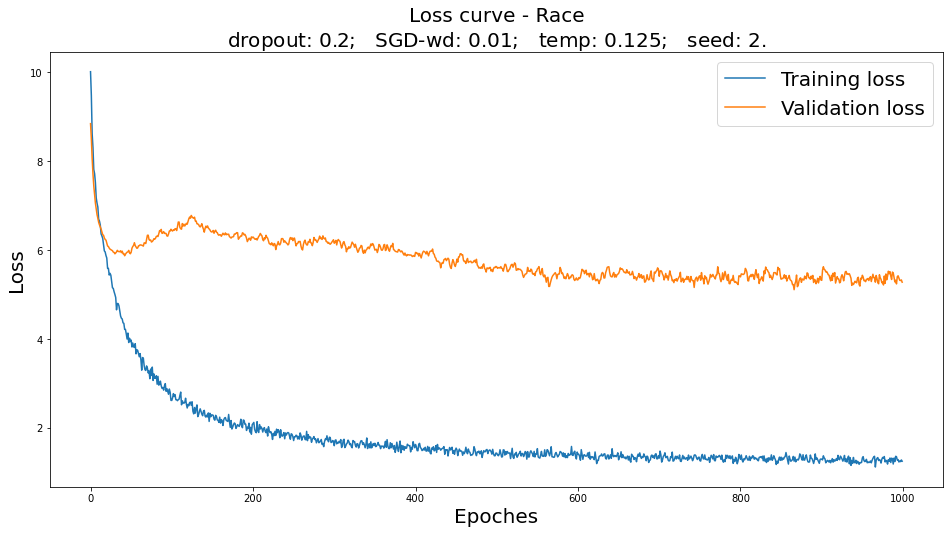

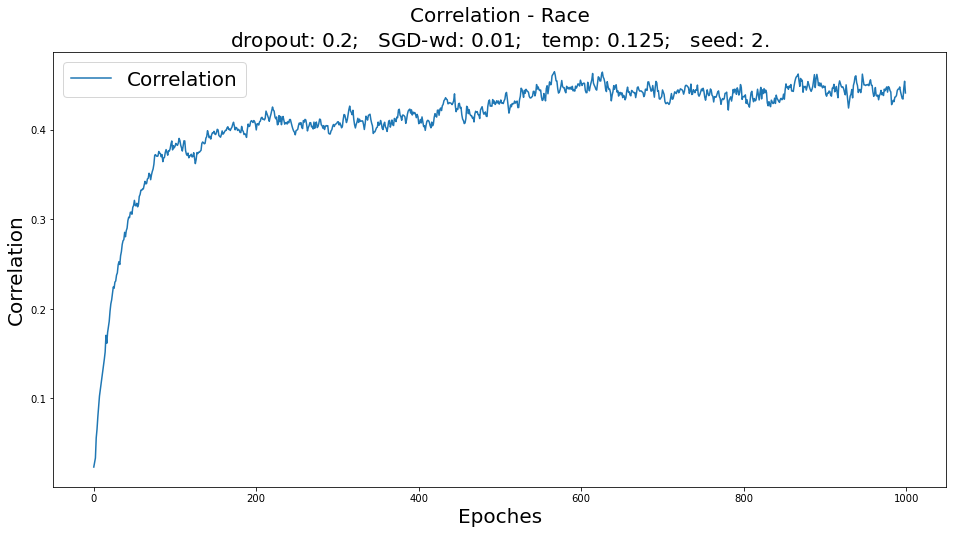

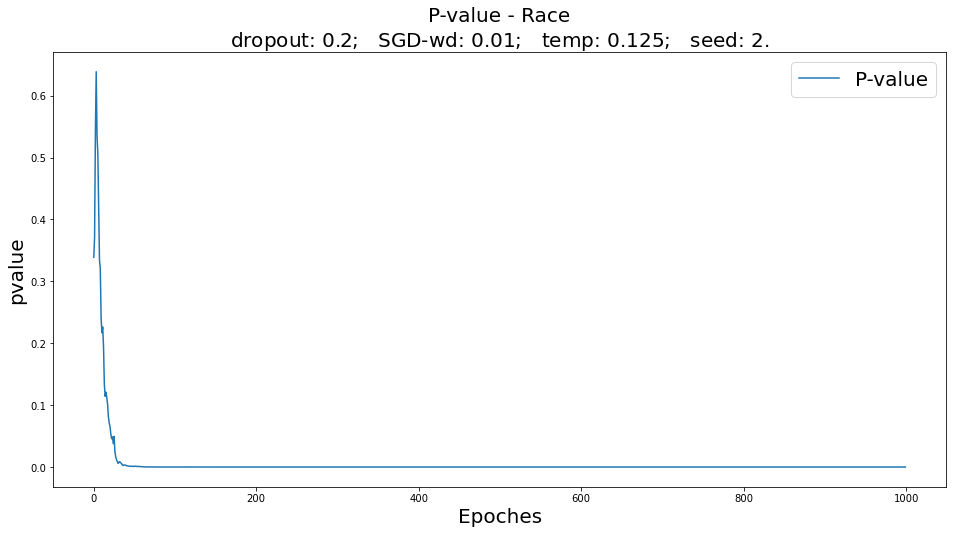


Race
n train: 501
n val: 105
n test: 112


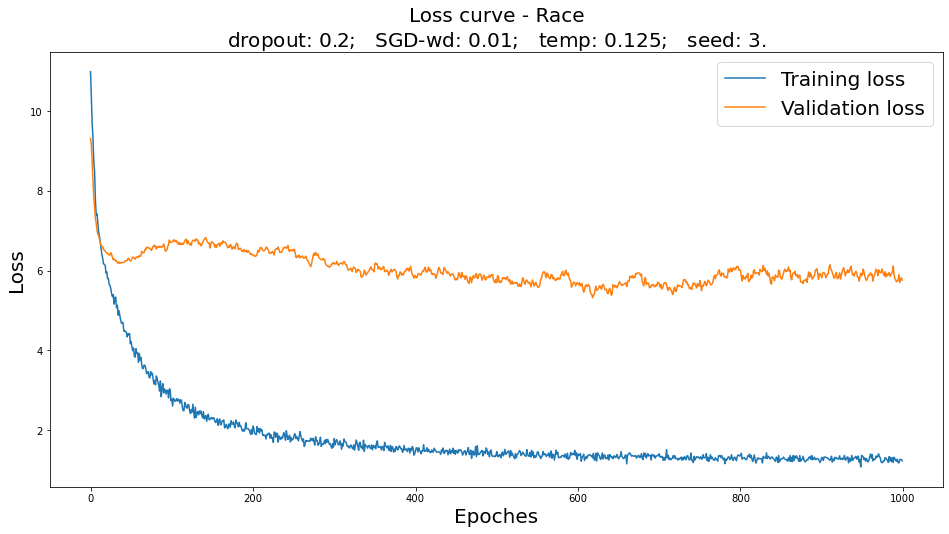

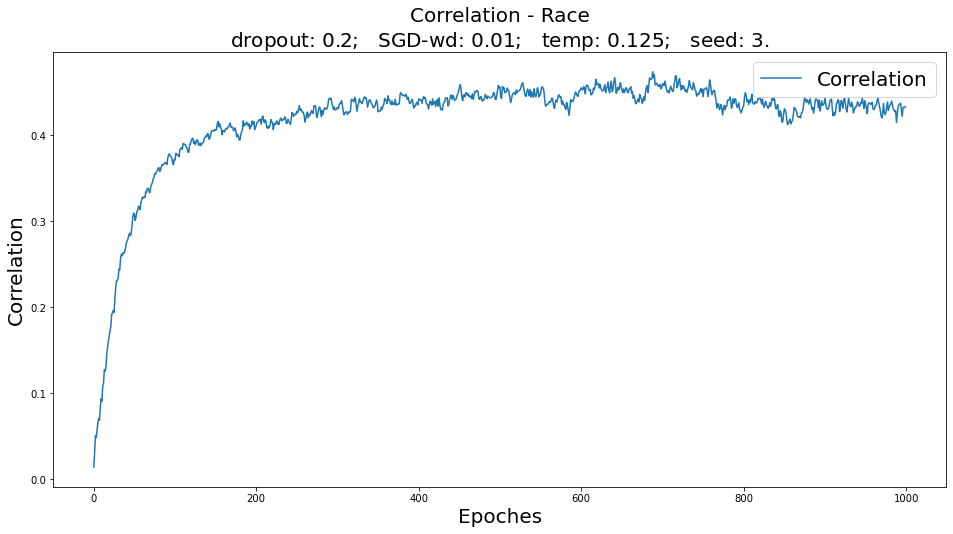

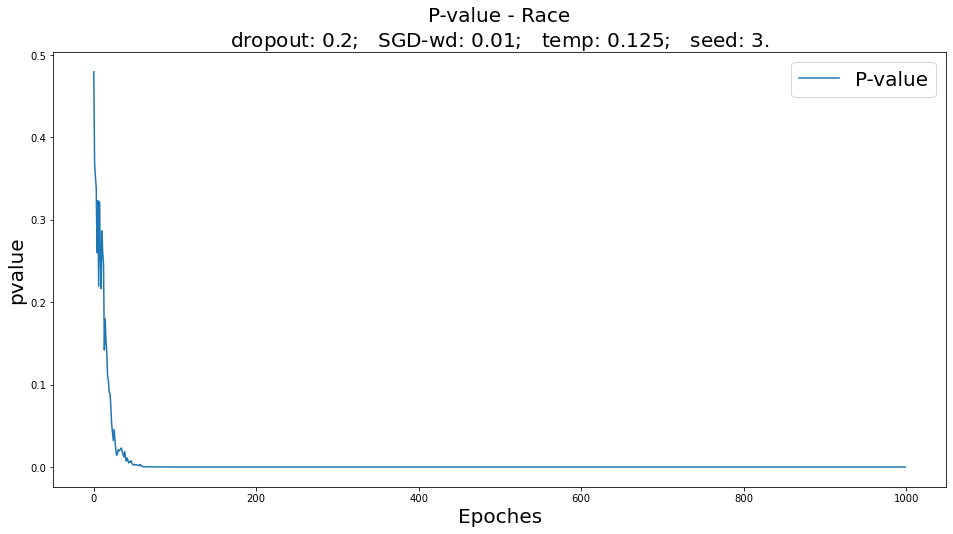


Race
n train: 501
n val: 105
n test: 112


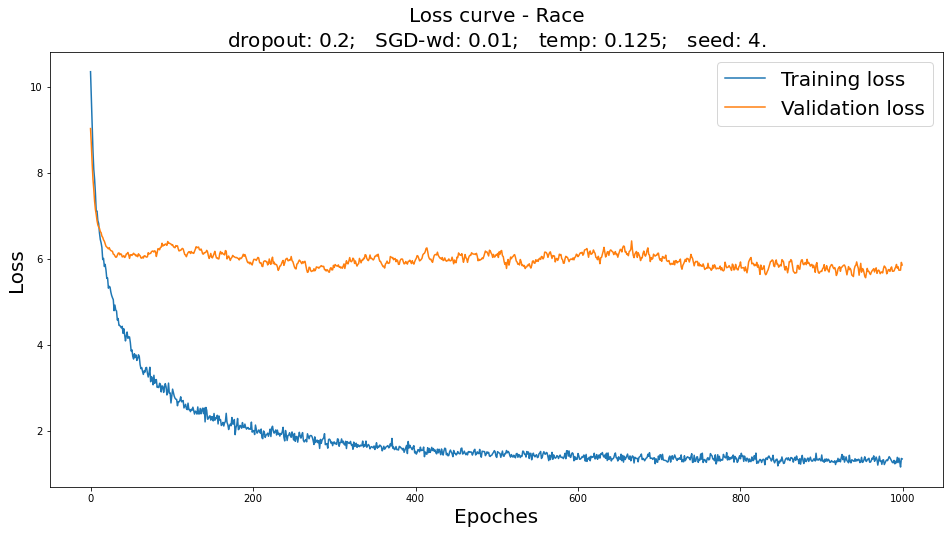

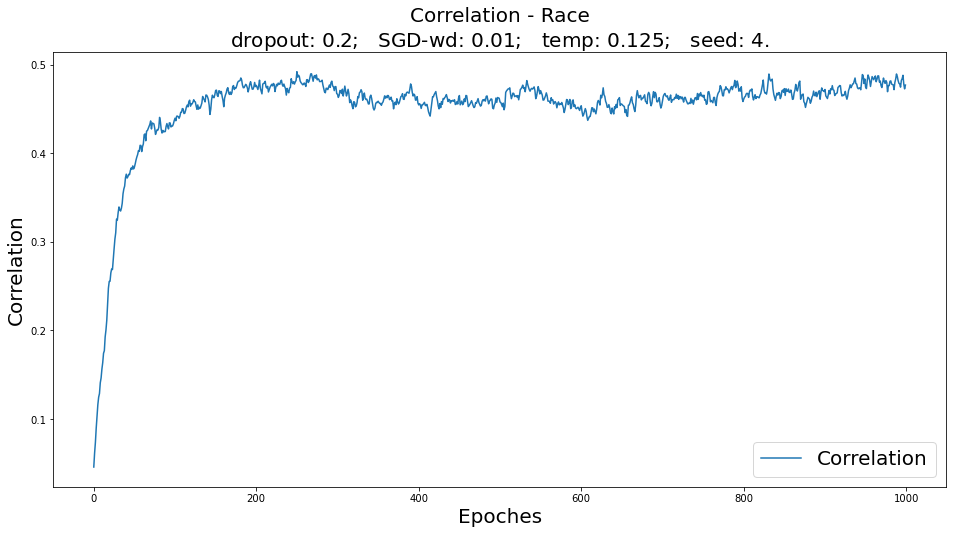

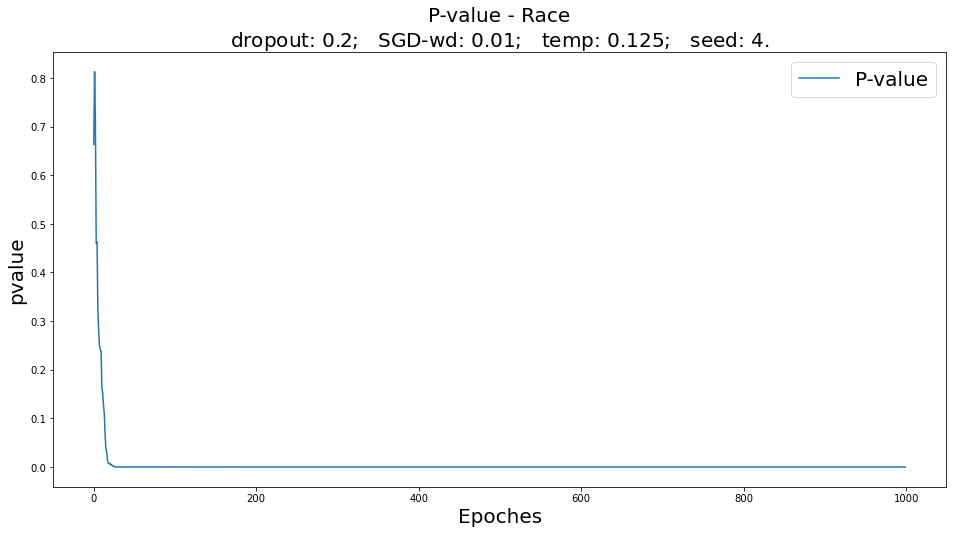


Race
n train: 501
n val: 105
n test: 112


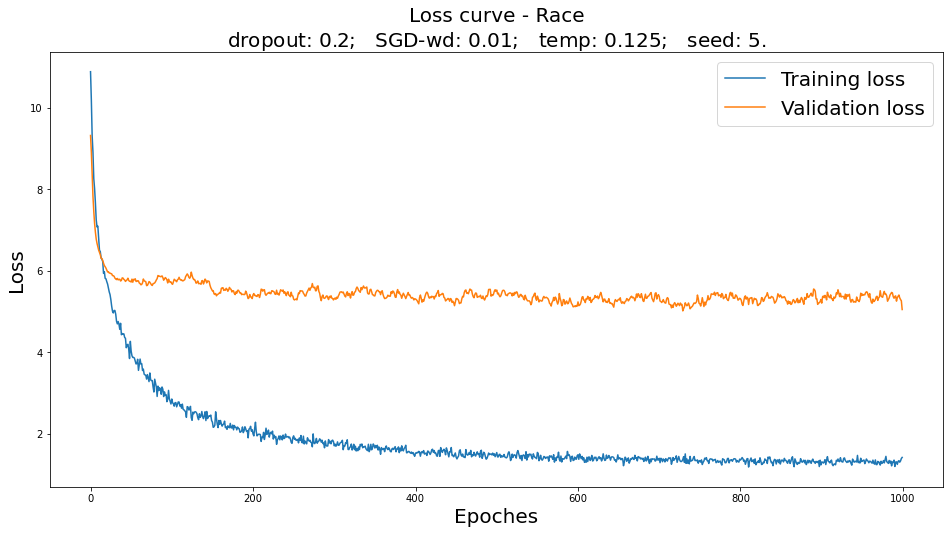

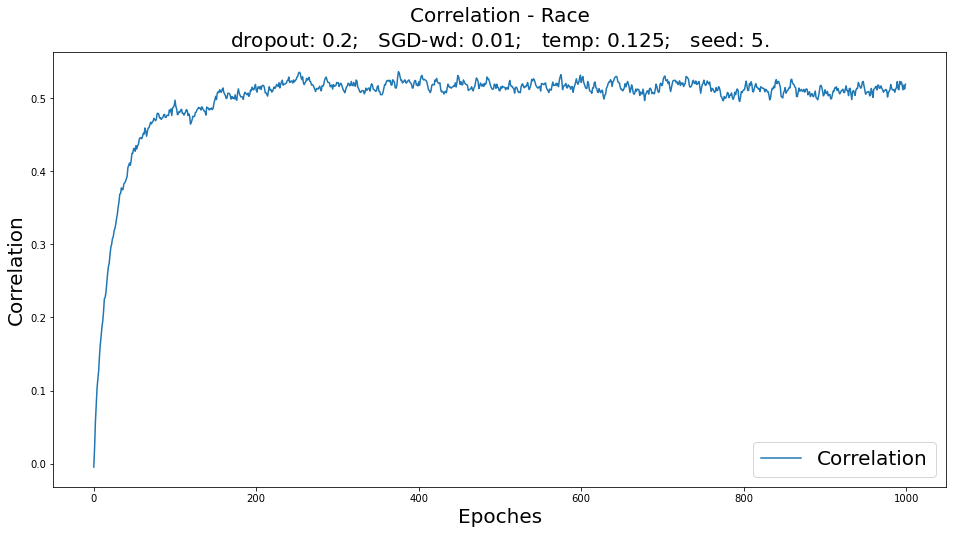

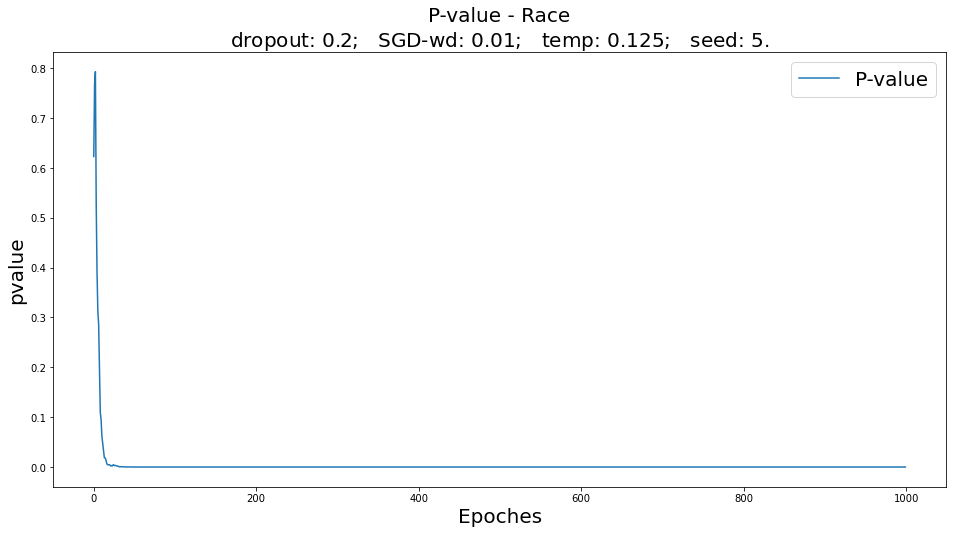


Race
n train: 501
n val: 105
n test: 112


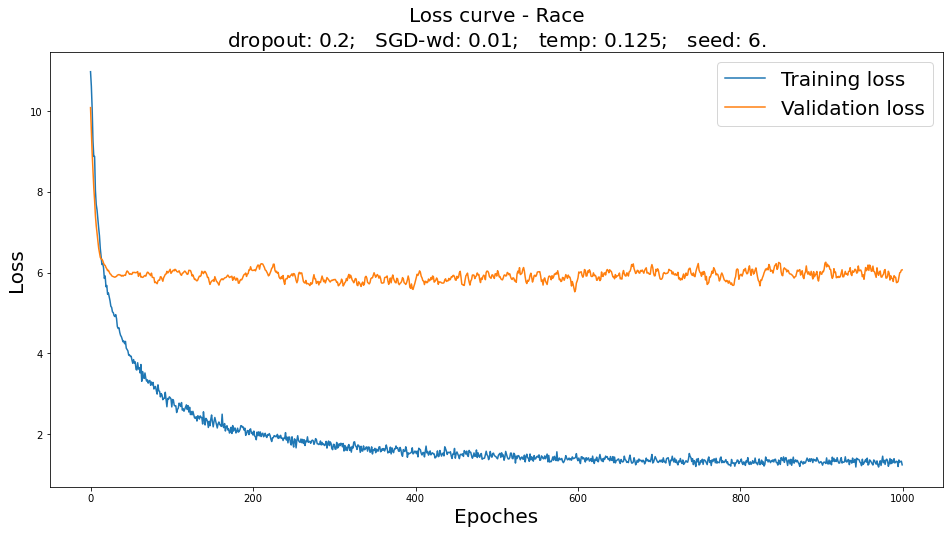

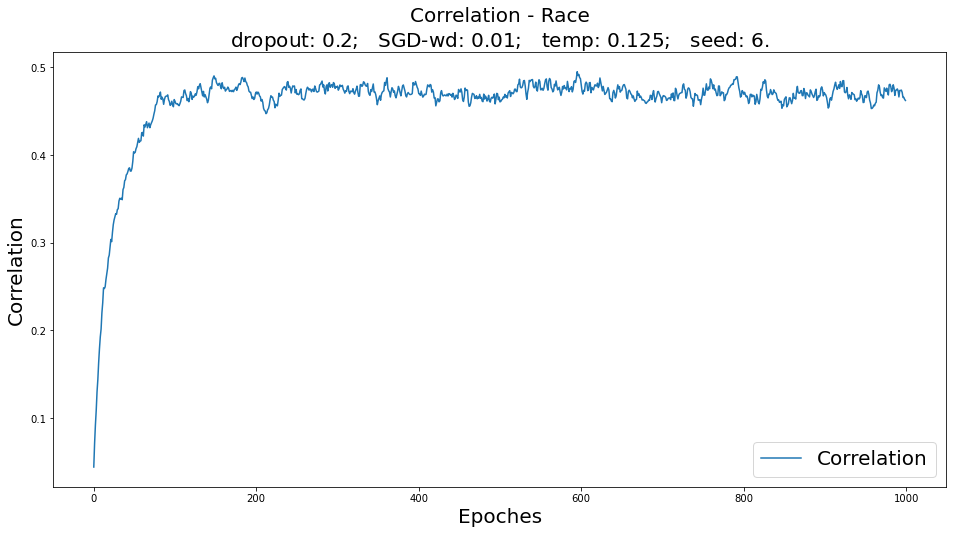

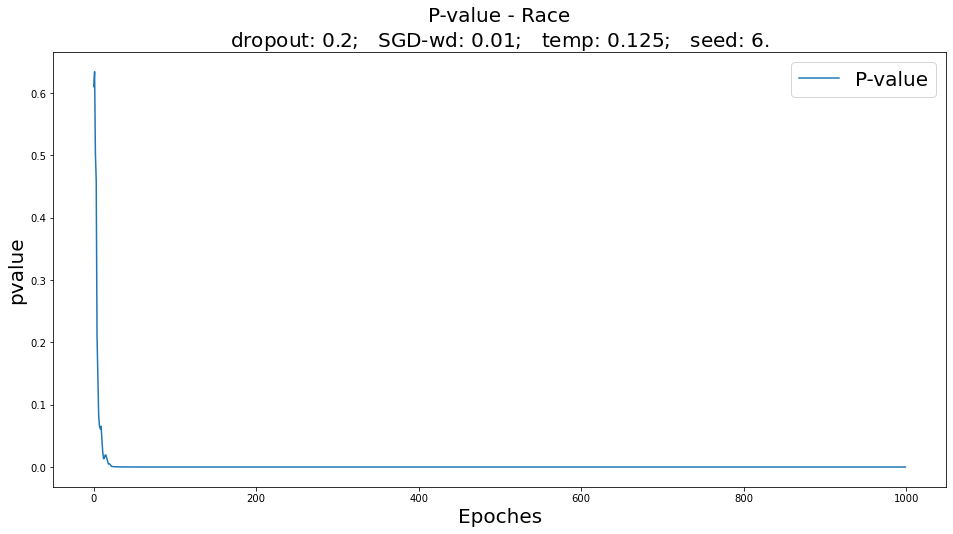


Race
n train: 501
n val: 105
n test: 112


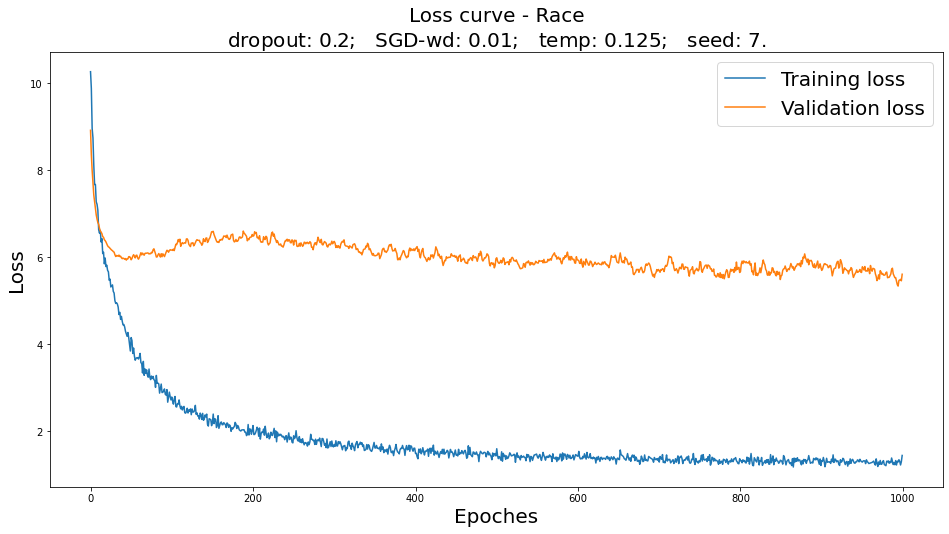

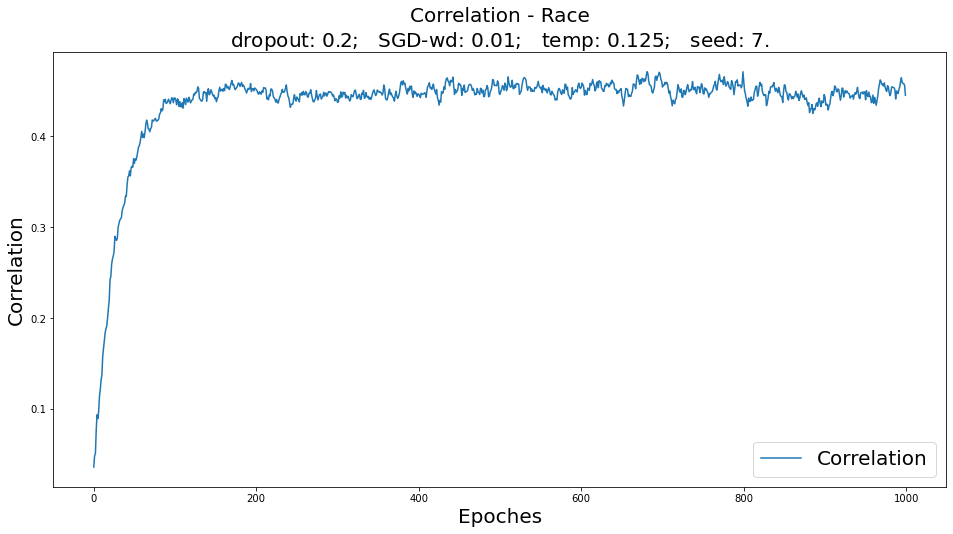

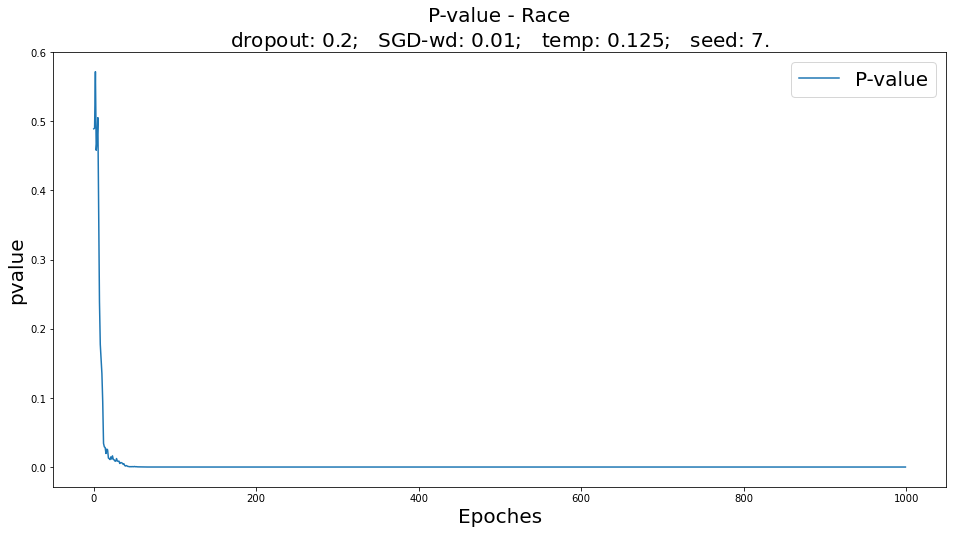


Race
n train: 501
n val: 105
n test: 112


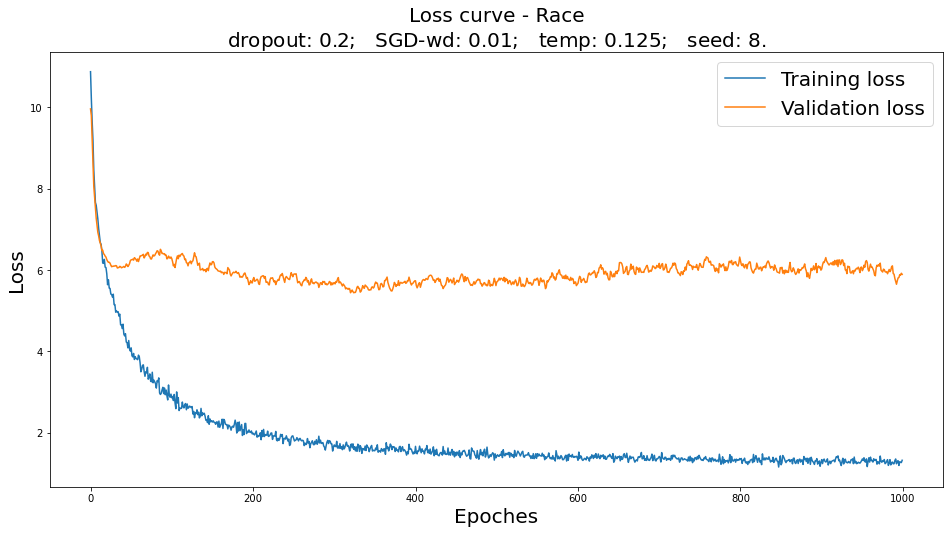

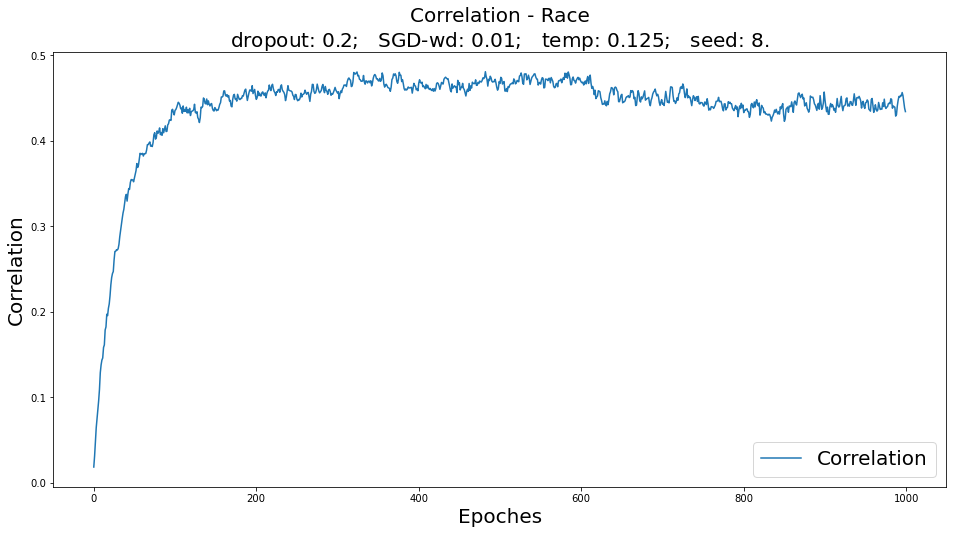

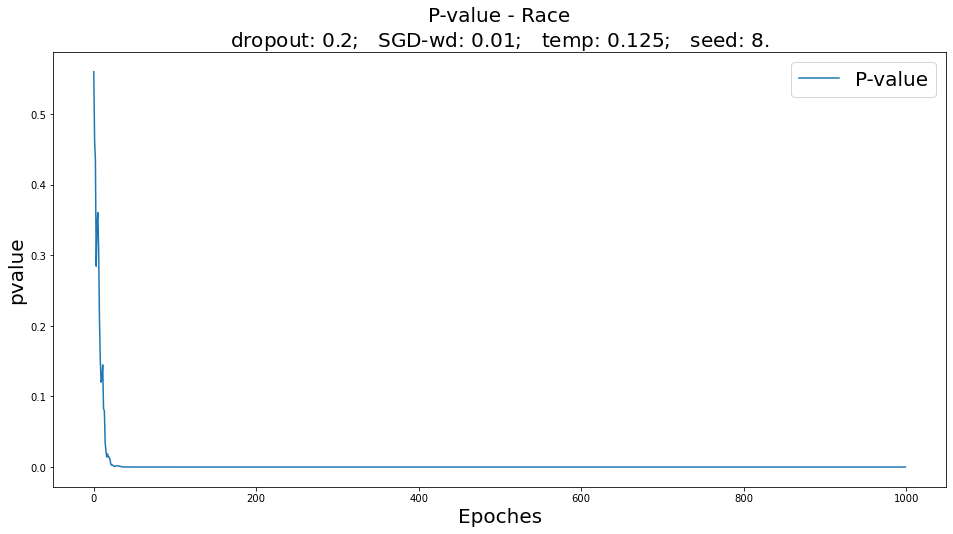


Race
n train: 501
n val: 105
n test: 112


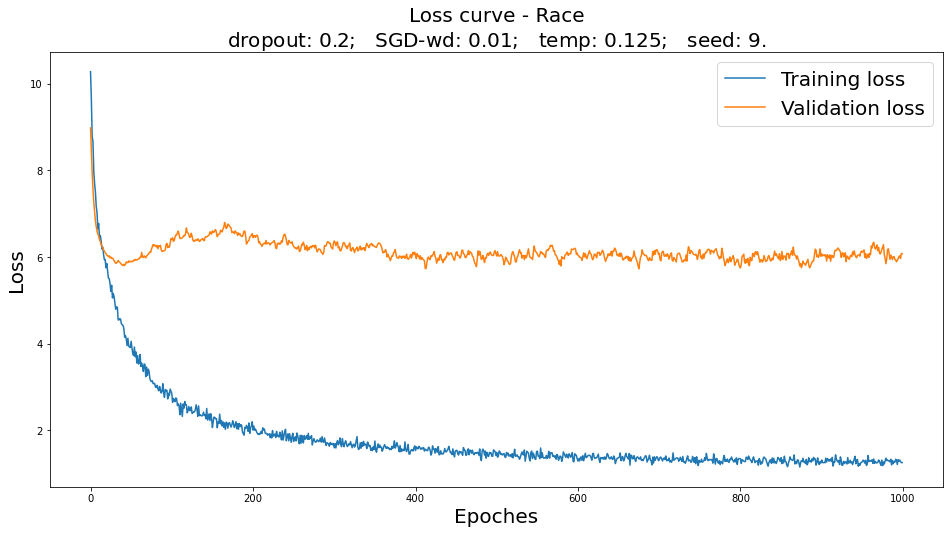

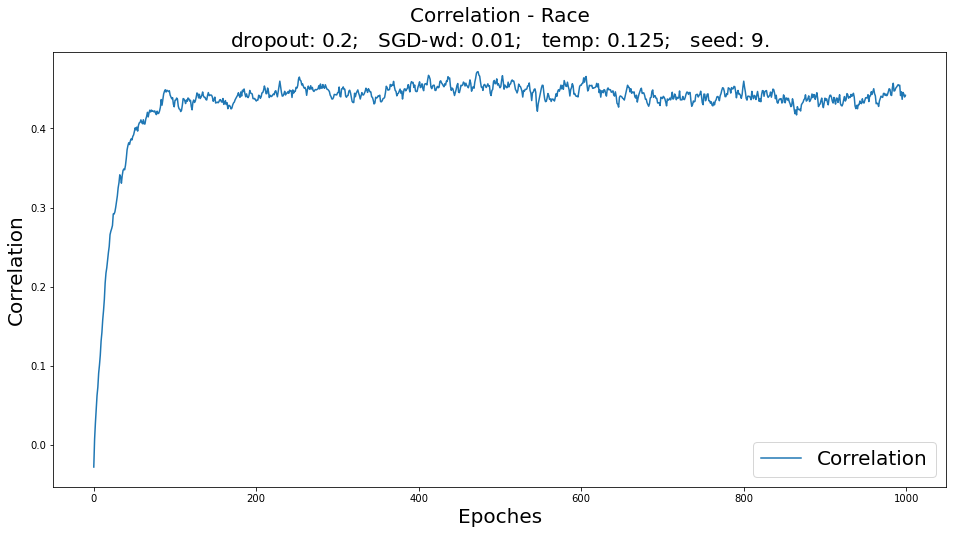

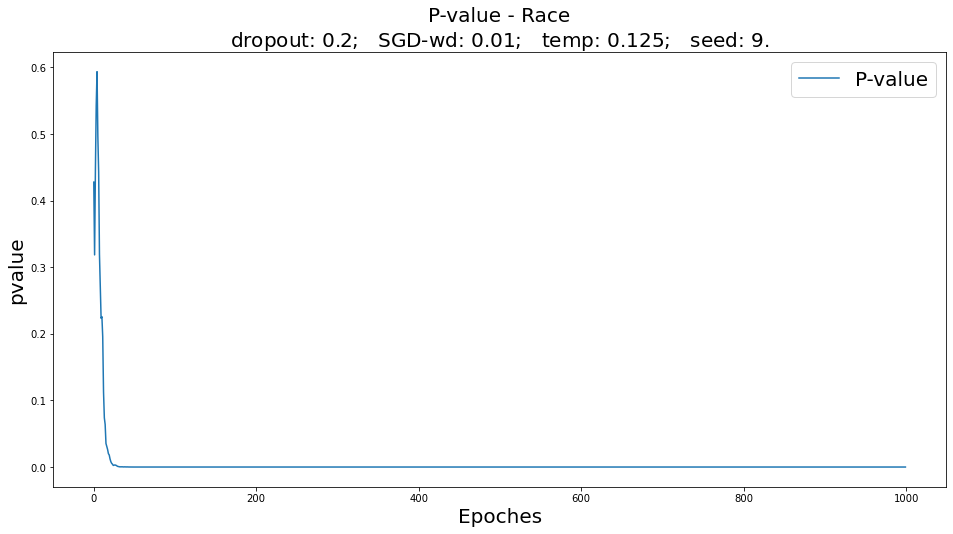


Race
n train: 501
n val: 105
n test: 112


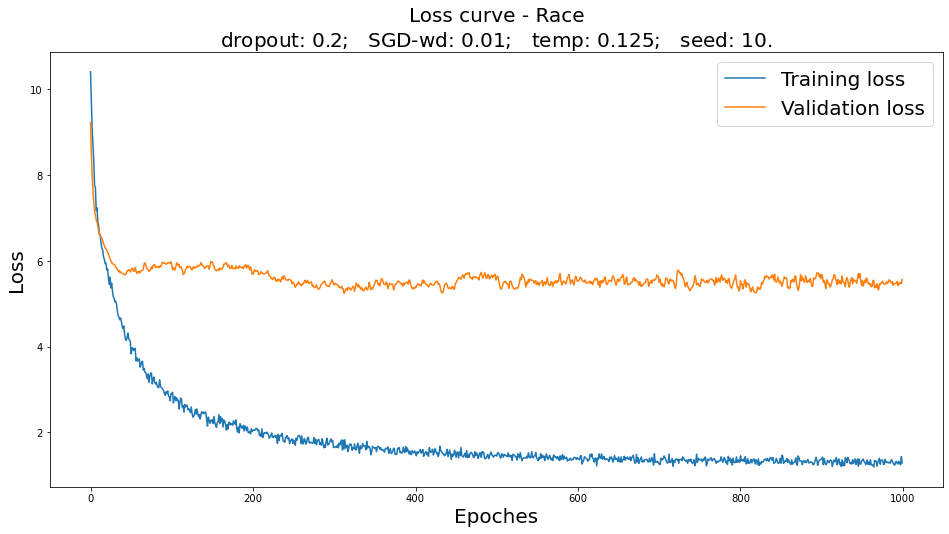

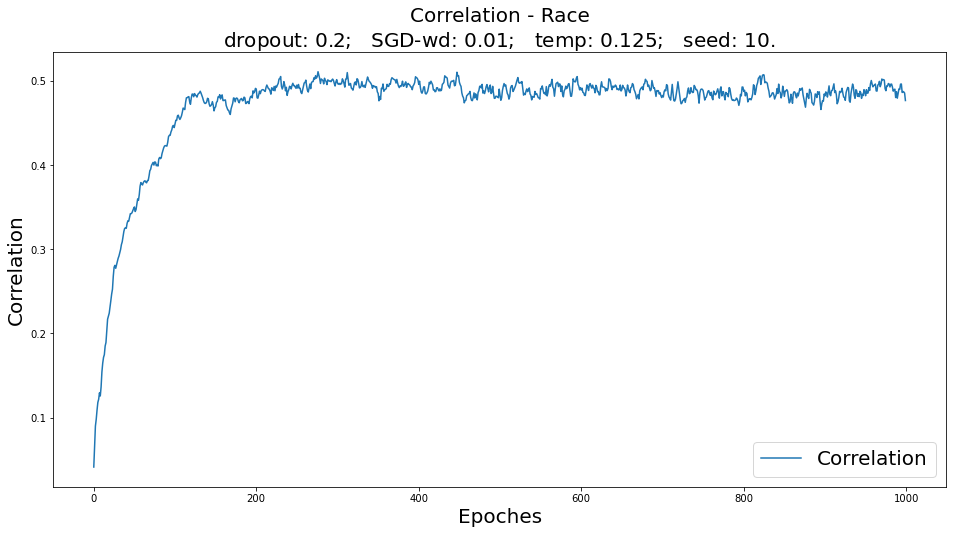

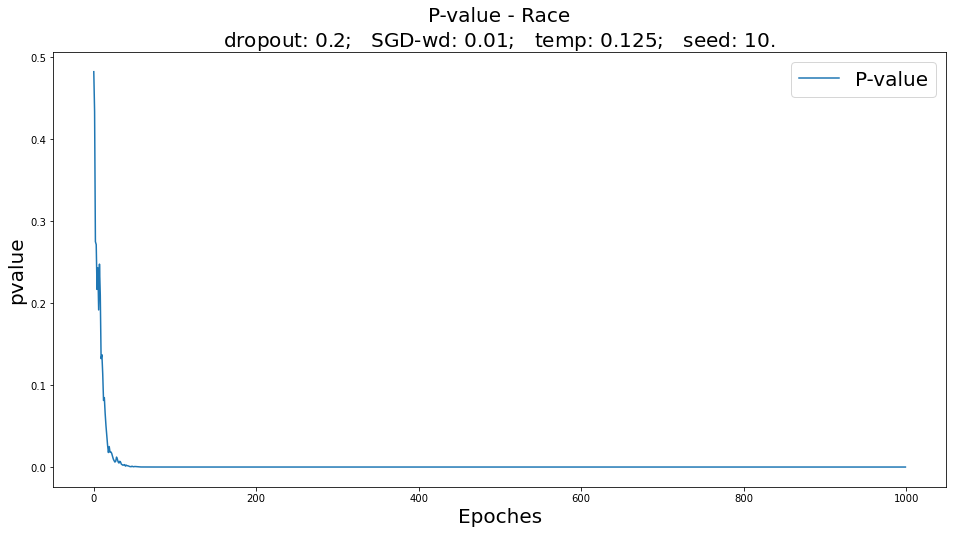


Race
n train: 501
n val: 105
n test: 112


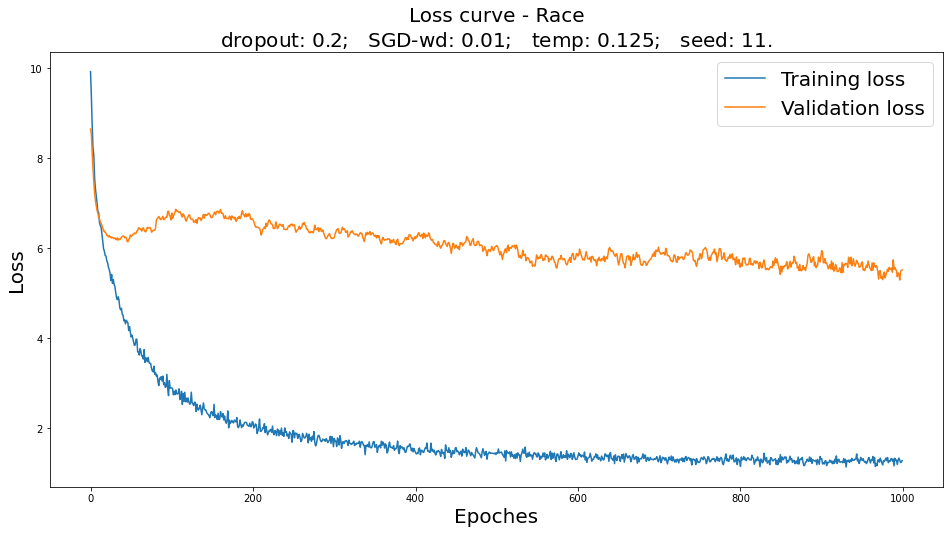

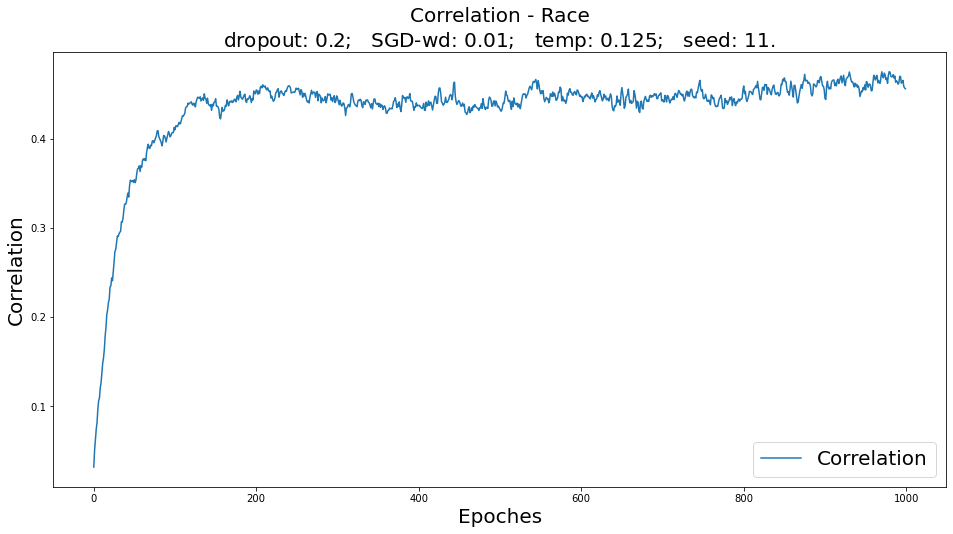

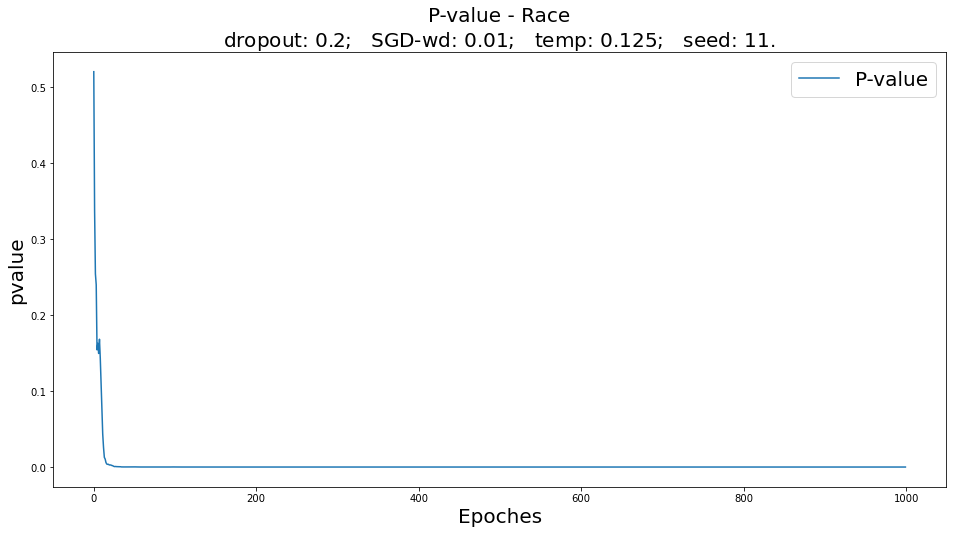


Race
n train: 501
n val: 105
n test: 112


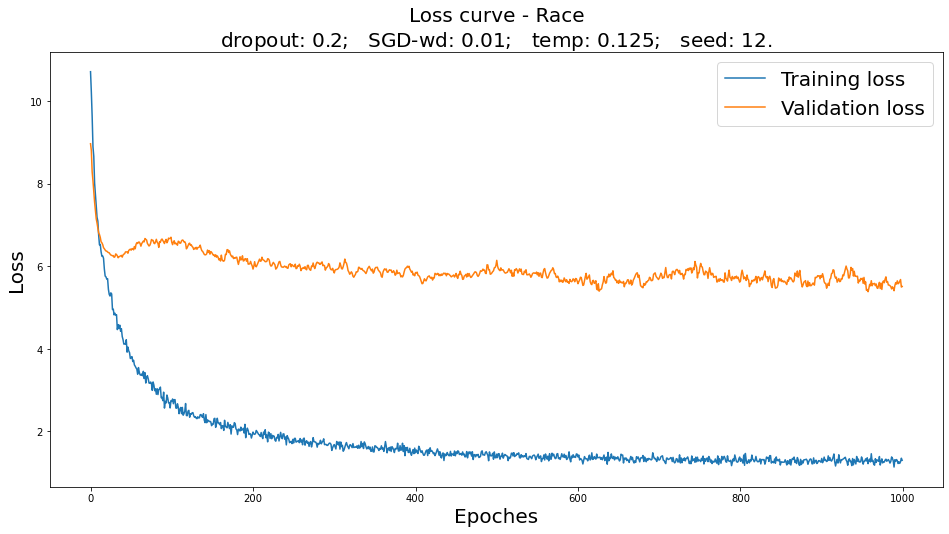

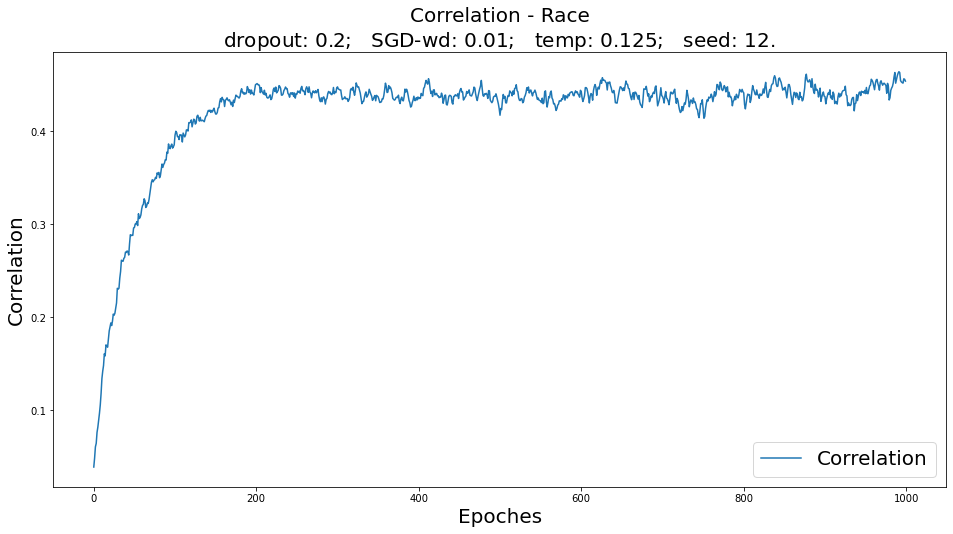

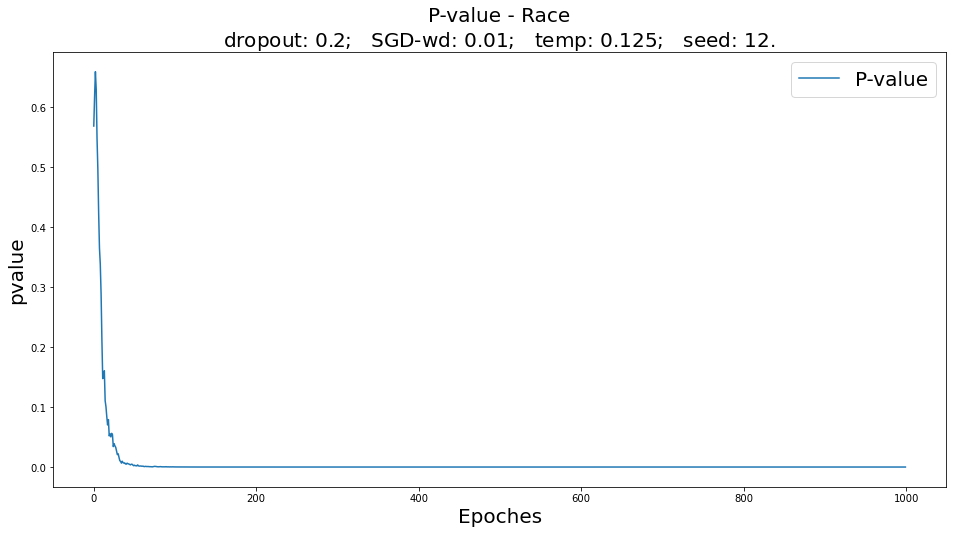

8773.012104034424
CPU times: user 2h 25min 6s, sys: 41.6 s, total: 2h 25min 47s
Wall time: 2h 26min 13s


In [7]:
%%time
start_time = time.time()

N_EPOCH = 1000
DEVICE = "cuda:3"

multi_omics_dict = {'gut_16s': gut_16s_df, 'metabolome': metabolome_df}
net_dict = {"gut_16s": [gut_16s_df.shape[1], 64, 16], 
            "metabolome": [metabolome_df.shape[1], 256, 64]}
predict_methods_list = ['logistic', 'svm', 'rf']

microbiome_accuracy_embedding_dict, metabolome_accuracy_embedding_dict = dict(), dict()

for covariate in covariate_list:
    dropout = dropout_list[max_idx[covariate][0]]
    weight_decay = weight_decay_list[max_idx[covariate][1]]
    temperature = temp_list[max_idx[covariate][2]]
    
    microbiome_valtest_accuracy_embedding = dict(list(zip(predict_methods_list,
             np.zeros(shape=(len(predict_methods_list), len(random_seed_list), 2)))))
    metabolome_valtest_accuracy_embedding = dict(list(zip(predict_methods_list,
             np.zeros(shape=(len(predict_methods_list), len(random_seed_list), 2)))))
    for s, seed in enumerate(random_seed_list):
        MB_simCLR = MbSimCLRModel(covariate=covariate, indexes=indexes, multi_omics_dict=multi_omics_dict,
                                 df_with_covariates=gut_16s_df_subj, device=DEVICE,
                                 root_folder=SAVE_FOLDER, random_seed=seed)
        MB_simCLR.initialize(net_dict=net_dict, temperature=temperature,
                             dropout_rate=dropout, weight_decay=weight_decay)
        MB_simCLR.train_model(n_epoch=N_EPOCH, print_hist=False)
        MB_simCLR.plot_training(save=True)
        MB_simCLR.save_training()
        MB_simCLR.save_embedding()
                    
            
        ### Predict based on embeddings by using different predictors
        predict_embedding_by_method_dict = dict()
        accuracy_embedding_dict = dict.fromkeys(MB_simCLR.keys)
        for method in predict_methods_list:
            predict_embedding_by_method_dict[method] = MB_simCLR.predict_embedding(predict_method=method)
            microbiome_valtest_accuracy_embedding[method][s] = \
                [predict_embedding_by_method_dict[method]['gut_16s']['val'][0],
                predict_embedding_by_method_dict[method]['gut_16s']['test'][0]]
            metabolome_valtest_accuracy_embedding[method][s] = \
                [predict_embedding_by_method_dict[method]['metabolome']['val'][0],
                predict_embedding_by_method_dict[method]['metabolome']['test'][0]]

    microbiome_accuracy_embedding_dict[covariate] = microbiome_valtest_accuracy_embedding
    metabolome_accuracy_embedding_dict[covariate] = metabolome_valtest_accuracy_embedding

import pickle
with open(os.path.join(SAVE_FOLDER, 'microbiome_accuracy_embedding_dict.pkl'), 'wb') as f:
    pickle.dump(microbiome_accuracy_embedding_dict, f)

with open(os.path.join(SAVE_FOLDER, 'metabolome_accuracy_embedding_dict.pkl'), 'wb') as f:
    pickle.dump(metabolome_accuracy_embedding_dict, f)
    
end_time = time.time()
print(end_time - start_time)

### Mean accuracy

In [8]:
microbiome_mean_accuracy_dict = dict()
for method in predict_methods_list:
    microbiome_mean_accuracy_dict[method] = \
            pd.DataFrame(index=covariate_list, columns=['Validation', 'Testing'])
    for covariate in covariate_list:
        microbiome_mean_accuracy_dict[method].loc[covariate,:] = \
            np.mean(microbiome_accuracy_embedding_dict[covariate][method], axis=0)

for method in predict_methods_list:  
    print(method)
    display(microbiome_mean_accuracy_dict[method].style.format(formatter="{:.2%}"))

logistic


svm


rf


## Result presentation

### Boxplots 

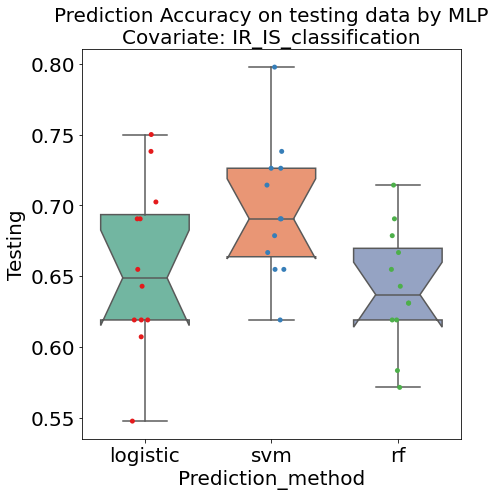

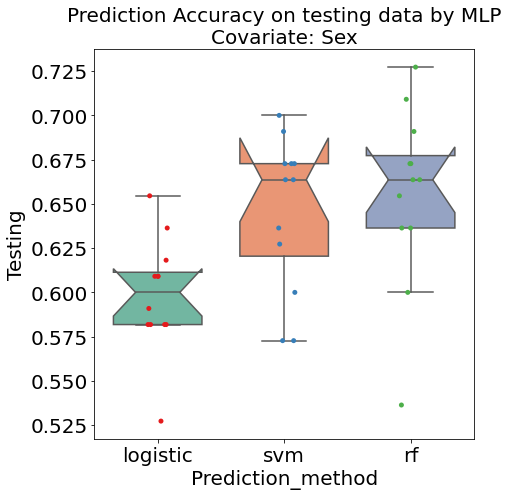

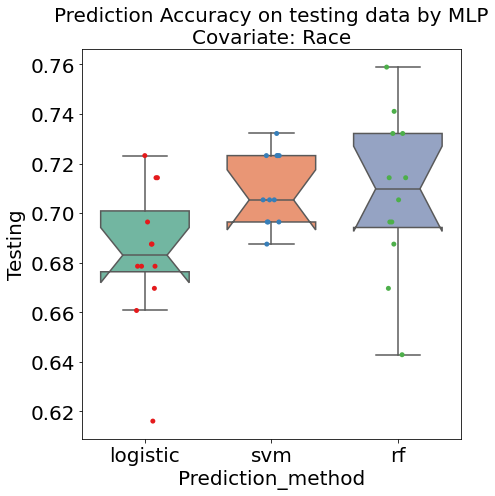

In [9]:
fontsize = 20
for covariate in covariate_list:
    accuracy_df = pd.DataFrame(columns=['Validation', 'Testing', 'Prediction_method'])
    for method in predict_methods_list:
        temp_df = pd.DataFrame(microbiome_accuracy_embedding_dict[covariate][method], 
                                              columns=['Validation', 'Testing'])
        temp_df['Prediction_method'] = [method] * 12
        accuracy_df = pd.concat([accuracy_df, temp_df], axis=0)
        
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6,6))
    plt.tight_layout()
    ax = sns.boxplot(x='Prediction_method', y='Testing', data=accuracy_df, 
                     notch=True, palette='Set2', width=0.7, showfliers = False)
    ax = sns.stripplot(x='Prediction_method', y='Testing', data=accuracy_df, 
                       jitter=True, dodge=True, marker='o', palette='Set1')
    ax.set_title('{}\nCovariate: {}'.format('Prediction Accuracy on testing data by MLP', covariate), fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)
    plt.show()